# Проработка вариантов решения

Задачи на текущий этап:
* Проанализировать имеющиеся решения
* Обозначить основные плюсы и минусы каждого из потенциальных решений
* Выбрать подходящее решение (алгоритм или набор алгоритмов) для данной задачи и обосновать его

Прежде, чем выбрать алгоритмы, которые будут использоваться в этой задаче, нужно проанализировать исходные данные.

Данные включают в себя: 

* Временную зависимость (мы работаем с последовательными действиями клиентов, что может быть полезно учесть). Однако у нас очень ограниченное временное окно (всего 2 дня), поэтому говорить о каких-то долгосрочных трендах не приходится.

* Множество метаданных, которые, как показал этап EDA, несут в себе большое количество информации, которая поможет составить более качественные рекомендации. Следовательно, нам нужны модели, которые учитывают не только коллаборативную, но и контентную информацию, то есть гибридные модели

* Сам объём данных довольно внушительный, а вычислительные мощности и время сильно ограниченны. Следовательно, чтобы добиться и хорошей точности, и вычисления были "дешевле", воспользуемся двухэтапной архитектурой. Причем на этапе грубой фильтрации попробуем несколько алгоритмов, а так же посмотрим, насколько изменится качество модели, если на втором этапе воспользоваться результатом всех алгоритмов первого этапа 

# Двухэтапная архитектура

Двухэтапная архитектура в рекомендательных системах представляет собой подход, при котором процесс формирования рекомендаций разбивается на два этапа: первый этап - грубая фильтрация (pre-filtering), второй этап - точная рекомендация (post-filtering). 

1. Грубая фильтрация (pre-filtering):
На этом этапе используются быстрые и простые алгоритмы для быстрого и грубого отбора кандидатов на основе общих характеристик или популярности. Например, можно использовать популярные товары или товары, которые похожи на те, которые пользователь уже просматривал.

Примеры алгоритмов для грубой фильтрации: популярные товары, коллаборативная фильтрация на основе соседей (например, User-Based CF или Item-Based CF).

Плюсы грубой фильтрации:
* Быстрота и эффективность: позволяет быстро сузить круг рекомендаций и уменьшить нагрузку на более сложные алгоритмы.
* Простота: не требует сложных вычислений или большого объема данных.

Минусы грубой фильтрации:
* Возможная низкая точность: из-за обобщенности и ограниченности критериев выбора кандидатов может быть низкая точность рекомендаций.
---
2. Точная рекомендация (post-filtering):
На этом этапе используются более сложные и точные алгоритмы для уточнения списка кандидатов, полученных на первом этапе. Эти алгоритмы могут учитывать более индивидуальные предпочтения пользователя, контентные характеристики товаров и другие дополнительные данные.

Примеры алгоритмов для точной рекомендации: коллаборативная фильтрация с использованием матричных разложений (например, SVD, ALS), содержательные методы (content-based filtering), гибридные методы.

Плюсы точной рекомендации:
* Высокая точность: более сложные алгоритмы могут учитывать более широкий спектр данных и предпочтений пользователей.
* Персонализация: возможность учитывать индивидуальные предпочтения пользователей.

Минусы точной рекомендации:
* Вычислительная сложность: более сложные алгоритмы могут требовать больше времени и ресурсов для обработки данных.
* Необходимость в большем объеме данных: для точной рекомендации часто требуется больше данных о пользователях и товарах.

Пример двухэтапной архитектуры в рекомендательной системе:
На первом этапе можно использовать популярные товары или товары, похожие на те, что пользователь уже просматривал. На втором этапе можно применить коллаборативную фильтрацию с использованием матричного разложения для уточнения и персонализации рекомендаций.

Двухэтапная архитектура позволяет достичь баланса между скоростью работы и точностью рекомендаций в рекомендательных системах. Популярной связкой алгоритмов является LightFM + Catboost.


# Алгоритмы для первого этапа

# TIFU KNN
Один из самых эффективных алгоритмов для решения задачи next basket recommendation

Примерный алгоритм следующий:
* Каждую корзину кодируем как вектор, где на i-й позиции стоит количество i-го товара в этой корзине
* Далее складываем все корзины каждого пользователя:
  * Либо как взвешенное среднее по всем корзинам
  * Либо как сумму векторов, умноженных на веса
  * !Старые корзины имеют меньший коэффициент (коэффициент r)
* По полученным векторам находим ближайших соседей (k_nearest) каждого пользователя и:
  * Либо берем итоговый вектор пользователя как взвешенное среднее по всем соседям и самому пользователю (чем дальше сосед, чем меньше коэффициент)
  * Либо находим взвешенное среднее по всем соседям, а дальше итоговый вектор получаем как P = v_user * alpha + v_avg_neighbors * (1 - alpha) (еще один коэффициент alpha)
* Далее находим позиции (top_k) в итоговом векторе каждого пользователя, где значения максимальны - это и есть рекомендации

В оригинальном алгоритме корзины каждого пользователя разбиваются на группы, но так как в среднем покупок у пользователя не так много, этот шаг можно будет убрать

Главный плюс: 
* Эта модель играет вокруг персональной частоты покупок пользователя. Если человек купил 100 раз определенный товар, именно TIFU KNN без проблем порекомендует его 101 раз и не ошибется. Остальные модели могут повторить персональные частоты, но все равно по качеству уступят TIFU KNN.

Минусы:
* Как у KNN
* Точность сильно зависит от гиперпараметров

# implicit knn (k Nearest Neighbours)

Следующий алгоритм коллаборативной фильтрации, основанный на предмете рекомендации - классический подбор соседей и реализован в библиотеке implicit. Работаем с разреженными матрицами, соответственно требуется предварительно сформировать разреженную матрицу c помощью scipy.sparse. 

Суть алгоритма: ищем в матрице по методу ближайших соседей айтемы, максимально похожие на айтемы из истории взаимодействий юзера, и рекомендуем ему их. Гиперпараметр один - К, число соседей. В implicit доступна модель CosineRecommender, она item-ориентирована, для поиска схожести между векторами товаров используется косинусное расстояние. Также реализация knn есть в sklearn.

Плюсы:
* Проработка комплементарных товаров
* Простая реализация
* Удобная и быстрая подготовка данных

Минусы:
* Требует много памяти, поскольку хранит большую часть или все данные
* Большие наборы данных приведут к задержкам по времени в работе алгоритма
* Склонен к переобучению


# LightFM 

LightFM использует подход матричной факторизации, где пользователи и предметы (например, продукты, фильмы) представляются в виде векторных эмбеддингов в латентном пространстве. Основные компоненты принципа работы LightFM:

1. Гибридный подход: LightFM объединяет коллаборативную фильтрацию (основанную на взаимодействиях пользователей и предметов) с контентными характеристиками (атрибутами пользователей и предметов). Это позволяет модели учитывать как поведенческие данные, так и дополнительную информацию.

2. Функции потерь: Для обучения модели используются различные функции потерь, такие как Bayesian Personalized Ranking (BPR), Weighted Approximate-Rank Pairwise (WARP) и тд. Выбор функции потерь зависит от типа задачи и доступных данных (например, явные или неявные рейтинги).

3. Обработка разреженных данных: LightFM эффективно работает с разреженными матрицами взаимодействий, что характерно для реальных рекомендательных систем, где взаимодействий между пользователями и предметами обычно мало по сравнению с возможными комбинациями.

Плюсы:
* Гибридный подход: Возможность объединять коллаборативную фильтрацию с контентным анализом позволяет улучшить качество рекомендаций, особенно в условиях «холодного старта» (когда мало данных о новых пользователях или предметах).
* Эффективность и масштабируемость: LightFM оптимизирован для работы с большими наборами данных, что делает его подходящим для промышленных приложений с большим числом пользователей и предметов.
* Гибкость настройки: Разнообразие функций потерь и возможность использования различных типов данных (явные/неявные рейтинги, дополнительные признаки) позволяют адаптировать модель под конкретные требования задачи.

Минусы:
* Ограниченная интерпретируемость: Как и многие методы матричной факторизации, LightFM может быть трудно интерпретируемым, что усложняет понимание причин конкретных рекомендаций.
* Чувствительность к качеству данных: Модель сильно зависит от качества и полноты входных данных. Недостаток или шумные данные о пользователях и предметах могут негативно сказаться на качестве рекомендаций.
* Требовательность к настройке: Для достижения оптимальных результатов требуется тщательная настройка гиперпараметров и выбор подходящей функции потерь, что может потребовать значительных вычислительных ресурсов и времени.

# EASE (Embarrassingly Shallow Autoencoders)

В отличие от сложных нейронных сетей, EASE представляет собой линейную модель, которая отличается высокой эффективностью и простотой при решении задач рекомендаций.

EASE основан на идее автокодеров, но значительно упрощён. Сами авторы оригинальной статьи говорят, что EASE можно рассматривать как автоэнкодер, как модифицированную версию SLIM и как подход, основанный на соседстве. Основные аспекты его работы включают:

1. Линейная реконструкция:
   - Цель модели — предсказать взаимодействия пользователя с предметами (например, покупки, оценки) исключительно на основе линейной комбинации других предметов, с которыми пользователь уже взаимодействовал.
   - Для каждого предмета создаётся отдельный линейный предиктор, который использует взаимодействия пользователя с остальными предметами для прогнозирования вероятности взаимодействия с этим конкретным предметом.

2. Векторное представление:
   - Пользователи представлены как векторы взаимодействий с предметами (разреженные векторы).
   - Модель обучается так, чтобы для каждого предмета находить веса для остальных предметов, минимизируя ошибку предсказания и контролируя сложность модели через регуляризацию.

3. Регуляризация:
   - В EASE используется L2-регуляризация (ридж-регрессия) для предотвращения переобучения и обеспечения разреженности матрицы весов.
   - Особое внимание уделяется отклонению диагональных элементов матрицы весов, чтобы избежать “утечки” информации (предотвращение использования самого предмета для его предсказания).

4. Решение системы линейных уравнений:
   - Обучение модели сводится к решению системы линейных уравнений, что делает процесс обучения очень быстрым и масштабируемым, особенно по сравнению с нелинейными моделями.

Считается лучшей моделью по мнению авторов из Сбера:

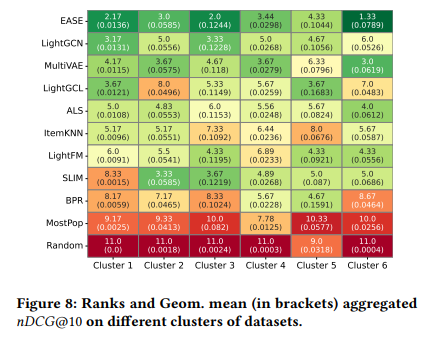

Плюсы: 
* Простота и скорость обучения:
   - EASE является линейной моделью, что обеспечивает быстрый процесс обучения даже на больших наборах данных.
   - Отсутствие сложных архитектур позволяет легко реализовать и масштабировать модель.
* Высокая точность рекомендаций:
   - Несмотря на свою простоту, EASE демонстрирует конкурентоспособные результаты, часто сравнимые с более сложными методами.
* Легкость интерпретации:
   - Поскольку модель линейна, веса можно непосредственно интерпретировать как влияние одного предмета на другой.
   - Это облегчает понимание того, какие предметы наиболее связаны между собой и как они влияют на рекомендации.

Минусы: 
* Ограниченная способность к моделированию сложных отношений:
   - Будучи линейной моделью, EASE не способна захватывать нелинейные зависимости между пользователями и предметами, что может ограничивать её эффективность в некоторых сценариях.
* Проблемы с большими каталогами предметов:
   - При очень большом количестве предметов размер матрицы весов может существенно увеличиваться, что приводит к высоким требованиям по памяти и вычислительным ресурсам.
   - Это может затруднить применение EASE в системах с миллионами предметов.
* Зависимость от плотности данных:
   - EASE сильно зависит от плотности взаимодействий в данных. В случаях, когда данные разрежены, модель может испытывать трудности с точным предсказанием.
   - Низкая плотность взаимодействий или большое количество отсутствующих данных могут негативно сказаться на качестве рекомендаций.

# Нейросетевая модель 

В качестве нейросетевого подхода мне бы хотелось создать гибридную нейросеть, примерная схема которой представлена на рисунке ниже

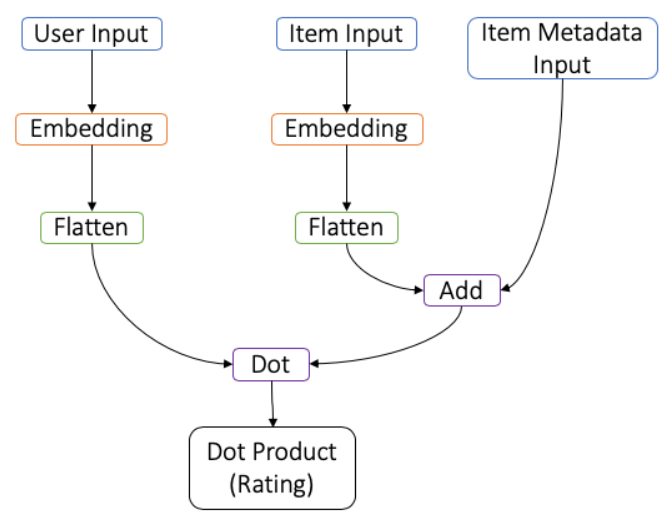

# Модель для второго этапа

В качестве модели для второго этапа будет использована вариация градиентного бустинга, например: XGBoost, CatBoost, LGBM 

# Остальные модели

Ниже представлен краткий обзор остальных моделей, которые я не буду использовать

# implicit ALS

Alternating least squares - это эвристический приближенный алгоритм для разложения матриц. На выходе снова получаем эмбеддинги юзеров и айтемов, с помощью которых делаем рекомендации.

Процесс оптимизации функции потерь будет иметь следующий вид.

В цикле до сходимости:

Фиксируем матрицу X(скрытые представления пользователей);

Решаем задачу L2-регуляризованной регрессии для каждого товара и находим оптимальную матрицу Y;

Фиксируем матрицу Y (скрытые представления объектов);

Решаем задачу L2-регуляризованной регрессии для каждого пользователя и находим оптимальную матрицу X;

Решение, получаемое путём попеременного вычисления точных аналитических решений, обычно точнее тех, что получаются с помощью наивного градиентного спуска. Более того, данное решение имеет эффективную реализацию, позволяющую использовать преимущества параллельных вычислений.

Явный фидбэк (оценки) пользователей доступен нам не всегда — и не всегда ему можно верить. Неявный фидбэк (количества просмотров/прослушиваний, покупок, добавлений в закладки) есть всегда и в гораздо большем количестве, а количество для машинного обучения критично.

Неявным фидбеком является в том числе и факт взаимодействия, поэтому мы можем заполнить всю матрицу user-item целиком: на тех позициях, где пользователь положительно взаимодействовал с объектом, поставим 1 а на тех, где взаимодействие было негативым или его вообще не произошло, поставим 0. Эта компонента фидбека называется предпочтением (preference):

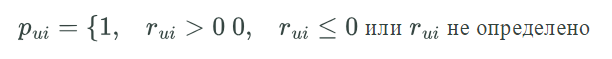

Введём ещё степень уверенности (confidence), отражающую уверенность в оценке пользователя:

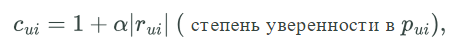

Тогда функция потерь будет иметь следующий вид:

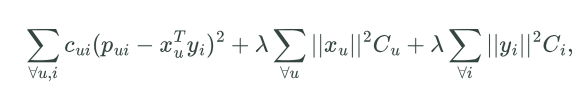


Она позволяет:

* Учитывать неявный фидбек, которого обычно на порядок больше, чем явного,
* Регулировать степень уверенности в действиях пользователей.

Плюсы:
* Эффективность при работе с разреженными данными
* Простота реализации и настройки
* Способность учитывать неявные взаимодействия

Минусы:
* Неустойчивость к выбору гиперпараметров: выбор оптимальных значений гиперпараметров в алгоритме implicit ALS может быть нетривиальной задачей и требует тщательного подбора.
* Требовательность к объему данных
* Ограничения на обработку контента: implicit ALS ориентирован на работу с данными о взаимодействиях пользователей, что ограничивает его способность учитывать контентные характеристики товаров при формировании рекомендаций.

# Singular Value Decomposition with implicit feedback (SVD++)

Ограничиваясь только одним типом фидбека (явным или неявным), мы теряем много информации. Учесть неявный фидбек в модели можно следующим образом:
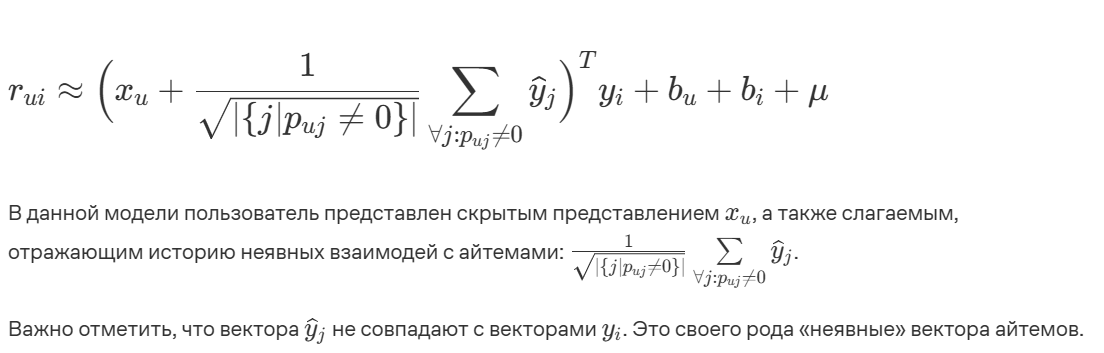

Плюсы:
* Учет неявных данных: SVD++ расширяет классическую SVD, интегрируя неявные отзывы пользователей (например, просмотры, клики), что улучшает качество рекомендаций.
* Улучшенная точность: Благодаря дополнительным данным модель способна лучше захватывать предпочтения пользователей и связи между элементами.
* Гибкость: Легко интегрируется с другими методами и может быть расширен для учета дополнительных факторов.

Минусы:
* Высокие вычислительные затраты: Обучение модели может быть ресурсоемким, особенно на больших наборах данных с неявными отзывами.
* Чувствительность к гиперпараметрам: Необходимостью тщательной настройки параметров, таких как число скрытых факторов, регуляризация и скорость обучения.
* Не учитывает временные изменения: Стандартная версия SVD++ не учитывает динамику предпочтений пользователей во времени.

# Collaborative Filtering with Temporal Dynamics (timeSVD++)

Особенностью всех рассмотренных на данный момент разложений является отсутствие учёта порядка просмотра объектов.

Однако, как показывает практика, со временем пользователь может менять своё мнение о тех или иных айтемах. Тогда, отсортировав взаимодействия по времени, мы можем разбить события на бакеты и модифицировать приведённую выше функцию потерь, в которой таргет выражается следующим образом:

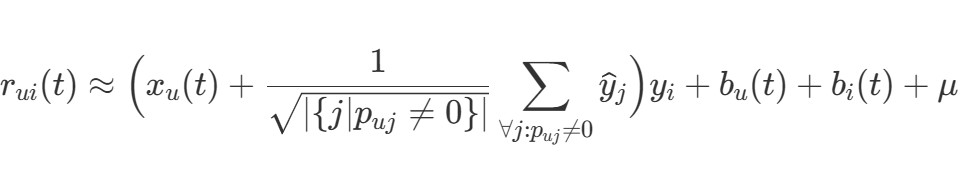

Плюсы:
* Учет временных факторов: В отличие от стандартного SVD++, timeSVD++ учитывает изменения во времени, что позволяет моделировать эволюцию предпочтений пользователей и популярности элементов.
* Повышенная точность: Учитывание временных аспектов зачастую приводит к более точным рекомендациям, особенно в динамичных областях (например, новости, фильмы).
* Гибкость во временных моделях: Возможность использовать различные подходы к моделированию временных изменений, например, разделение предпочтений на фиксированные и временные компоненты.

Минусы:
* Дополнительная сложность: Введение временных факторов увеличивает сложность модели и требует более тщательной настройки.
* Высокие вычислительные затраты: Учет временных аспектов может значительно увеличить время обучения модели, особенно на больших и разноплановых данных.
* Необходимость доступности временной информации: Требуется наличие точных и релевантных временных меток для отзывов пользователей, что не всегда доступно.

# SLIM - Sparse Linear Methods

Sparse Linear Methods

Описанные выше методы демонстрируют хорошее качество, однако требуют больших усилий для эффективной работы в онлайн сервисах. Возникает потребность в лёгких моделях, эффективность которых значительно выше, но качество которых не сильно хуже. Для этого была предложена линейная разреженная модель.

Принцип работы SLIM:

1. Изначально строится матрица схожести пользователей или товаров на основе их взаимодействий.

2. Применяется регуляризация для уменьшения переобучения и улучшения обобщающей способности модели.

3. Минимизируется функционал ошибки, который включает в себя как ошибку предсказания, так и регуляризационный штраф.

4. На основе обученной модели строятся рекомендации для пользователей.

В функции потерь (например MSE) используется L1 регуляризация:

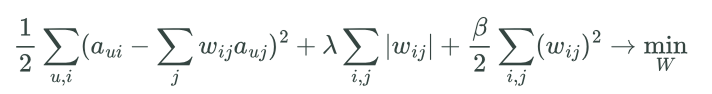

Матрицы получаются разреженными -> Эти обстоятельства позволяют заметно улучшить эффективность применения модели.

Плюсы:

* Эффективность при работе с разреженными данными: SLIM хорошо справляется с задачами рекомендаций в случаях, когда данные о взаимодействиях пользователей с товарами представлены в виде разреженной матрицы.

* Устойчивость к переобучению: использование регуляризации позволяет уменьшить переобучение модели и повысить её обобщающую способность.

* Гибкость и настраиваемость: SLIM позволяет настраивать различные параметры модели для достижения оптимальных результатов.

Минусы:

* Вычислительная сложность: SLIM может быть вычислительно затратным алгоритмом, особенно при работе с большими объемами данных.

* Необходимость в большом объеме данных: для эффективной работы SLIM требуется большое количество данных о взаимодействиях пользователей с товарами.

* Ограничения на обработку контента: SLIM ориентирован на работу с данными о взаимодействиях пользователей, что ограничивает его способность учитывать контентные характеристики товаров при формировании рекомендаций.





# Matrix Factorization Neural Networks

Матрицичная факторизация нейронных сетей представляет собой класс моделей, которые объединяют традиционные методы матричной факторизации с архитектурами нейронных сетей для улучшения представления и предсказательной мощности. Такие модели особенно популярны в задачах рекомендаций, где требуется учитывать сложные взаимодействия между пользователями и объектами.

#### Примеры моделей Matrix Factorization Neural Networks

1. NeuMF (Neural Matrix Factorization):
   - Описание: Комбинирует GMF (Generalized Matrix Factorization) и MLP (Multi-Layer Perceptron) для объединения линейных и нелинейных взаимодействий между пользователями и товарами.
   - Преимущество: Способность захватывать как линейные, так и сложные нелинейные паттерны взаимодействий.

2. Deep Matrix Factorization (Deep MF):
   - Описание: Интегрирует глубокие нейронные сети с матричной факторизацией для улучшения представления латентных факторов.
   - Преимущество: Повышенная способность к обобщению за счет использования глубоких структур.

3. Collaborative Deep Learning (CDL):
   - Описание: Объединяет матричную факторизацию с глубокими автоэнкодерами для совместного обучения латентных представлений.
   - Преимущество: Улучшенное использование дополнительных данных и моделей глубокого обучения.

4. Neural Collaborative Filtering (NCF):
   - Описание: Использует нейронные сети для моделирования функций взаимодействия между пользователями и предметами, заменяя традиционные матричные операции.
   - Преимущество: Гибкость в моделировании сложных отношений и взаимодействий.

#### Отличие от других методов матричной факторизации

Традиционные методы матричной факторизации, такие как SVD (Singular Value Decomposition) или ALS (Alternating Least Squares), фокусируются на разложении исходной матрицы на произведение двух или более матриц низкого ранга, что позволяет выявить скрытые (латентные) факторы. В отличие от них, Matrix Factorization Neural Networks включают в себя нейронные сети для дополнительного моделирования сложных, нелинейных взаимодействий между латентными факторами пользователей и предметов.

Основные отличия:

1. Нелинейность:
   - Традиционные методы обычно моделируют линейные взаимодействия.
   - Нейронные сети способны захватывать нелинейные зависимости благодаря использованию активационных функций и множественных слоев.

2. Глубина модели:
   - Традиционная матричная факторизация имеет ограниченную выразительную мощность.
   - Нейронные сети могут иметь множество скрытых слоев, что повышает их способность к представлению сложных паттернов.

3. Обучение и оптимизация:
   - Традиционные методы используют оптимизацию на основе градиентного спуска или специфические алгоритмы как ALS.
   - Нейронные сети обучаются методом обратного распространения ошибки с использованием стохастического градиентного спуска и его вариантов.

Плюсы:

* Высокая гибкость и выразительная мощность: Способность моделировать сложные, нелинейные зависимости между пользователями и предметами.
* Лучшее представление данных: Способность извлекать более информативные и обобщающие латентные представления.
* Интеграция дополнительных данных: Возможность включения различных видов данных (например, контекстуальной информации, метаданных) через нейронные сети.
* Улучшенная точность предсказаний: Обычно показывают более высокие метрики точности по сравнению с традиционными методами.

Минусы:
* Сложность обучения: Более сложные архитектуры требуют тщательной настройки гиперпараметров и значительных вычислительных ресурсов.
* Риск переобучения: Сложные модели могут переобучаться на тренировочных данных, особенно при ограниченном объёме данных.
* Интерпретируемость: Латентные факторы, извлечённые с помощью нейронных сетей, могут быть менее интерпретируемыми по сравнению с традиционными методами.
* Требования к данным: Для эффективного обучения нейронных сетей требуется большое количество данных, что может быть проблемой в некоторых приложениях.

# Neural collaborative filtering (NCF)

NCF как и matrix factorization опирается на коллаборативный данные неявного фидбэка. Но пытается в отличии от него уйти от скалярного произведения в качестве меры схожести, поскольку NCF может изучить более сложные зависимости. Основная идея NCF в том, чтобы сделать эту меру более сложной и обучаемой.

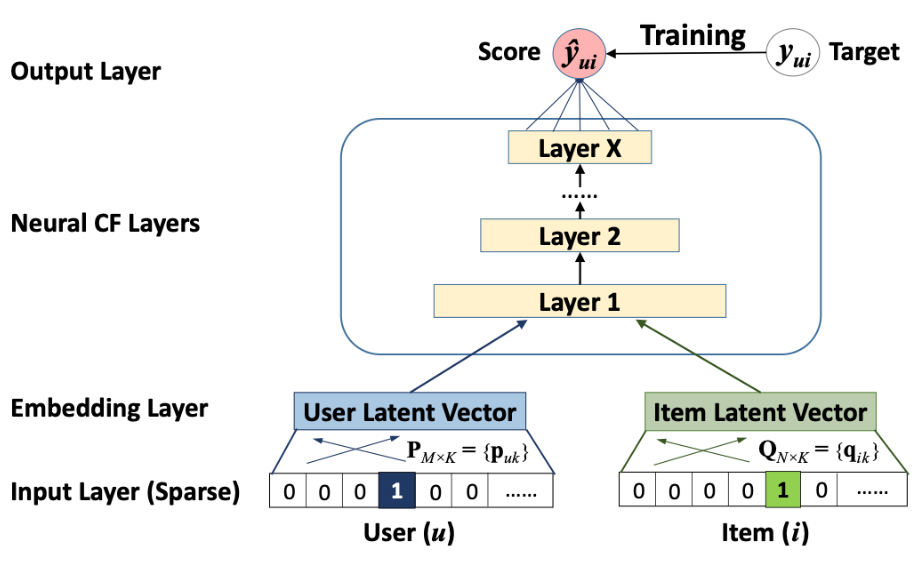

Входные данные могут быть разными, но изначально используются чистые коллаборативные данные, закодированные one-hot encoding. В ситуации холодного старта входными данными могут послужить метаданные контента и пользователей. За входным слоем находится полносвязный, который отвечает за преобразование разреженного one-hot представления в плотные эмбеддинги. После получения эмбеддинги конкатинируются, а дальнейшая архитектура носит имя neural collaborative filtering и отвечает за преобразование эмбеддингов пары пользователь-объект непосредственно в предсказание.

В данном случае стандартная среднеквадратичная ошибка может не отвечать виду реальных данных неявного фидбэка, которые представлены значениями 0 и 1. Потому используется вероятностный подход к обучению NCF. Если предсказанное число рассматривать как вероятность значения 1 (то есть релевантности объекта пользователю) и ограничить выход сети диапазоном [0,1], то можно использовать log loss.

NCF получается более общим вариантом классического матричного разложения, которое можно в точности воспроизвести, если упростить слои идущие за слоем эмбеддингов.

В оригинальной статье приводятся результаты теста NCF в сравнении с классическими методами такими как KNN, рекомендация популярного и ALS матричное разложение на двух датасетах: MovieLens и Pinterest. Согласно тесту NCF демонстрирует лучшую стабильно более высокие результаты на обоих наборах данных. 

# Факторизационные машины

Первоначально факторизационные машины использовали только коллаборативный сигнал, но, в такую модель можно естественным образом добавить и контентную информацию.

Факторизацонную машину можно обучать для решения разных задач. Например:
* Предсказание рейтинга. Ответ модели a(x) можно интерпретировать, как вещественный рейтинг, и решать задачу регрессии.
* Бинарную классификацию рекомендовать/не рекомендовать. Тогда a(x) имеет смысл логита, и мы можем оптимизировать оптимизировать log loss или hinge loss.
* Ранжирование объектов. Тогда a(x) – это ранжирующая функция.

Модель обычно обучается градиентным спуском.

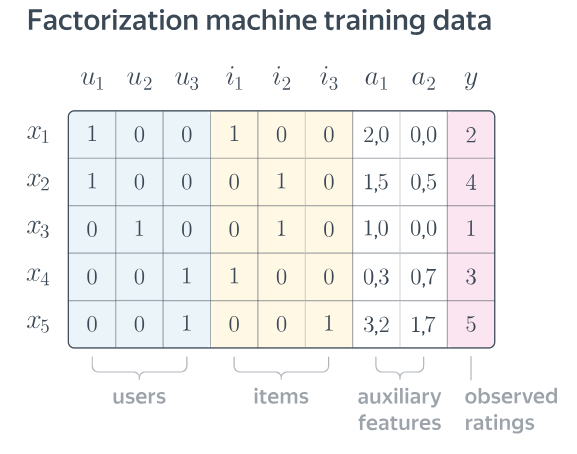

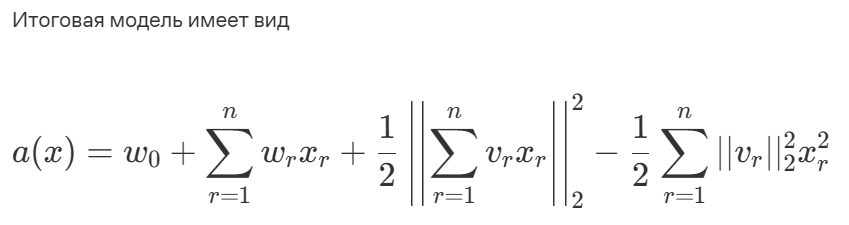

Плюсы:
* Эффективность при работе с разреженными данными: Хорошо справляются с высокоразреженными матрицами, что важно для задач рекомендаций и рекламы.
* Гибкость в моделировании взаимодействий: Способны учитывать взаимодействия между признаками любого порядка, обеспечивая универсальность применения.
* Высокая скорость обучения: Эффективные алгоритмы оптимизации позволяют быстро обучать модель даже на больших наборах данных.

Минусы:
* Ограниченная способность моделировать сложные зависимости: Хорошо работают с двухсторонними взаимодействиями, но испытывают трудности с нелинейными зависимостями.
* Необходимость тщательной настройки гиперпараметров: Требуют внимательной подгонки параметров факторизации и регуляризации для достижения наилучших результатов.
* Слабая интерпретируемость временных аспектов: Стандартные FM не учитывают временные изменения данных или предпочтений пользователей.


# FFM – Field-aware Factorization Machines

Как следующий этап развития факториационных машин, появилась идея иметь несколько различных латентных представлений для каждой из фичей.

Пример: есть три разных по своей природе признака: год выпуска, цвет и марка автомобиля. В факторизационной машине для учёта взаимодействия год-цвет и год-марка используется один и тот же вектор для года. Но так как эти признаки разные по смыслу, то и характер их взаимодействия может отличаться.

Идея: использовать 2 разных вектора для признака «год выпуска» при учёте взаимодействий год-цвет и год-марка. Таким образом, модель принимает вид:

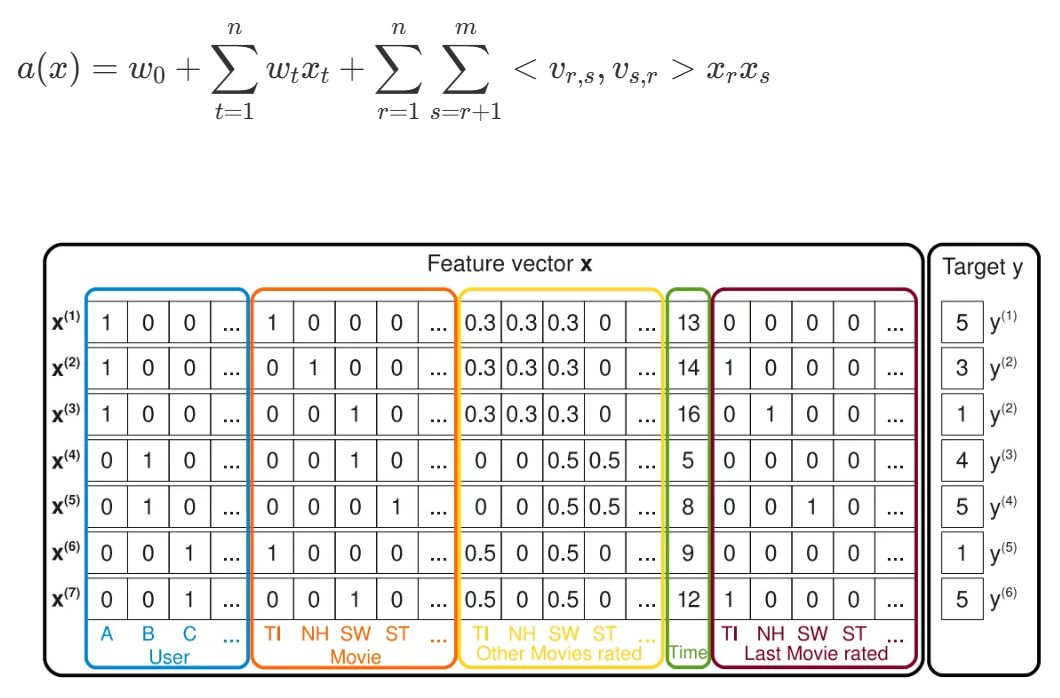

Плюсы:
* Улучшенное моделирование взаимодействий: Учитывают принадлежность признаков к разным полям, что повышает точность взаимодействий.
* Высокая точность в задачах рекламы: Особенно эффективны в предсказании кликов (CTR) и других рекламных приложениях благодаря детализированному учёту признаков.
* Гибкость при работе со структурированными данными: Позволяют учитывать структуру данных за счёт разделения признаков по полям.

Минусы:
* Увеличенная вычислительная сложность: Требуют больше параметров и вычислительных ресурсов из-за зависимости взаимодействий от полей признаков.
* Необходимость явного определения полей: Требуется предварительное разделение признаков на поля, что может быть не всегда удобно.
* Риск переобучения: Увеличение числа параметров модели может привести к переобучению, особенно при ограниченном объёме данных.

# Factorization Machines with Temporal Dynamics, FM-TD

### Принцип работы

Факторизационные машины с временной динамикой (FM-TD) расширяют стандартные FM, интегрируя временные компоненты для моделирования изменений во взаимодействиях признаков с течением времени. Основные подходы к внедрению временной динамики в FM включают:

1. Добавление временных признаков: Введение дополнительных временных признаков (например, временных меток, сезонности) в модель, позволяющее учитывать временные изменения данных.

2. Временные факторизации: Модификация матрицы факторов так, чтобы она зависела от времени. Это может включать использование раздельных векторов факторов для разных временных интервалов или введение временных коэффициентов.

3. Динамические компоненты: Интеграция динамических систем или рекуррентных нейронных сетей для моделирования эволюции факторов во времени.

4. Временные регуляризации: Применение специальных методов регуляризации для поддержки гладкости или преемственности во временных изменениях факторов.

Пример реализации: В контексте рекомендательных систем FM-TD могут учитывать изменение предпочтений пользователей со временем, предоставляя более точные предсказания на основе исторических взаимодействий и их временных меток.

Плюсы:

* Учёт временных изменений: Позволяют моделировать эволюцию взаимодействий между признаками со временем, что особенно важно в динамичных средах, где предпочтения пользователей или поведение меняются.
* Увеличение точности предсказаний: Интеграция временной динамики может привести к более точным предсказаниям, так как модель учитывает не только статические взаимодействия, но и их временную составляющую.
* Гибкость в адаптации: Возможность настройки модели под различные временные масштабы и паттерны, такие как сезонность, тренды или внезапные изменения в данных.

Минусы:

* Увеличенная вычислительная сложность: Введение временной динамики требует дополнительных вычислений, что может значительно повысить время обучения и потребление ресурсов, особенно на больших наборах данных.
* Сложность настройки гиперпараметров: Необходимо тщательно подбирать параметры, связанные с временными компонентами (например, размер временных окон, степень влияния прошлых данных), что усложняет процесс оптимизации модели.
* Риск переобучения: Дополнительные временные параметры и компоненты могут увеличить риск переобучения, особенно если количество данных относительно небольшое или временные паттерны недостаточно выражены.

# DSSM (deep sematic similiarity model)

Теперь рассмотрим ещё одну популярную модель, которая использует контентную информацию для построения рекомендаций – DSSM.

В оригинальной статье DSSM была использована для нахождения «схожести» между поисковым запросом и документом. Для этого она использовала текст запроса и текст документа.

DSSM представляет из себя «двуногую» (two-tower) нейронную сеть. В исходной постановке на первый вход подаётся текст запроса, а на второй – текст документа. Далее, независимо для текста запроса и текста документа строятся эмбеддинги. Итоговая «схожесть» вычисляется, как косинусная мера близости между ними.

На схеме ниже Q – это запрос (query), а D – документ (document).

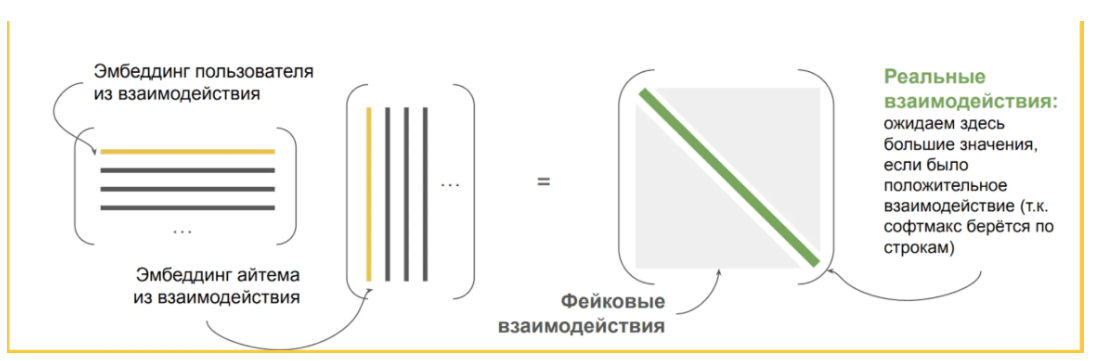

Некоторые авторы пытались в качестве меры близости рассматривать вместо косинусной меры обучаемый MLP, но это оказалось гиблой идеей.

Эта архитектура оказалась крайне удобной при использовании на практике, так как эмбеддинги пользователя и объекта можно предподсчитать независимо и дальше хранить сразу готовые представления для них, а при запросе к рекомендациям просто пересчитывать меру близости, что ускоряет применение модели.

Данная идея хорошо обобщается на построение рекомендаций. Поиск релевантных объектов можно представить, как задачу ранжирования, где вместо текстов запроса и документа мы будем иметь некоторую контентную информацию о пользователе и объекте.

Плюсы:
* Глубокое представление данных: Используют глубокие нейронные сети для создания богатых признаковых представлений, улучшая качество предсказаний.
* Эффективность работы с неструктурированными данными: Отлично подходят для обработки текста, изображений и других неструктурированных данных.
* Способность к обучению сложных зависимостей: Могут моделировать сложные нелинейные связи между признаками и целевыми переменными.

Минусы:
* Высокая вычислительная нагрузка: Требуют значительных вычислительных ресурсов и времени для обучения, особенно на больших наборах данных.
* Сложность в настройке и обучении: Имеют множество гиперпараметров, требующих тщательной настройки для оптимальной производительности. Склонны к переобучению и требуют больших объемов данных.
* Сложность интерпретации результатов: Глубокие модели часто рассматриваются как "черные ящики", затрудняя понимание механизмов принятия решений.

# Word2Vec

Довольно просто представить, что объекты — это слова, а последовательности взаимодействия с ними в рамках одной сессии (или пользователя) — это предложения. NLP-модели используют скользящее окно небольшого размера, а значит, позволяют учитывать еще не последовательность действий, но уже близость одного к другому в последовательности.

Есть два метода формирования train-набора данных. Один называется skip-gram — это угадывание окружения вокруг слова. Другая схема — это CBOW (continuous bag of words), угадывание слова по его окружению (словам вокруг).

Суть одна — выделить паттерны слов, которые часто встречаются вместе в одном контексте.

Получается модель, которая берёт входное и выходное слова и вычисляет вероятность их соседства. Но нужно ввести в набор данных отрицательные образцы — слова, которые точно не являются соседями. Это называется Skip-gram с отрицательной выборкой (SGNS).

Цель на этапе обучения — подобрать таки эмбеддинги для всех слов словаря, чтобы скалярное произведение их было бы мерой вероятности для этих слов встретиться пососедству.

Ключевые гиперпараметры word2vec: размер окна, количество отрицательных образцов и размерность эмбеддингов. В Gensim (известной библиотеке для обработки естественного языка, где реализован word2vec алгоритм) размер окна по умолчанию равен 5, и 5 отрицательных образцов берется на каждый положительный.

Общая архитектура CBOW-сети представлена на рисунке. Входной слой может быть расширен в зависимости от количества слов в рассматриваемом контексте. Используется разреженное one-hot encoding представление слов.

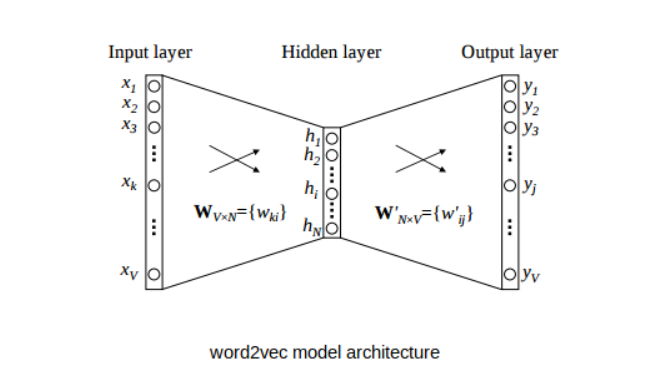

Рассмотрим конкретное применение в рекомендациях на примере Airbnb. В Airbnb используется skip-gram model. Если более формально, то функция L, которую максимизируют, выглядит так.

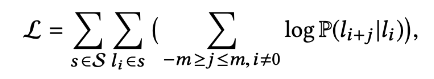

S — это сессии, каждая из которых состоит из последовательности кликов по l листингам (объектам размещения), v — обучаемые эмбеддинги.

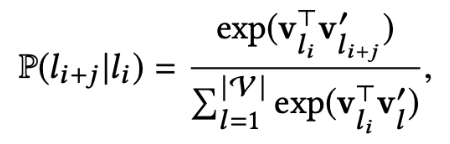

Вероятность P — это вероятность увидеть листинг l_i+j на расстоянии, которое мы считаем контекстом от листинга l_i. Где m — это параметр отражающий размер контекста. v_l и v_l со штрихом — это входной и выходной вектор эмбеддингов листинга l. При таком подходе листинги, встречающиеся в схожих контекстах, получат похожие эмбеддинги (как и со словами). Чтобы не считать градиент по всему «словарю» листингов используется подход позитивного и негативного семплинга пар таргет-контекст.

Из интересных решений: чтобы сделать дополнительный акцент на сессиях, закончившихся бронированием, бронирование добавляется как глобальный (дополнительный) контекст ко всем тренировочным примерам из сессий с бронированием независимо от размера окна.

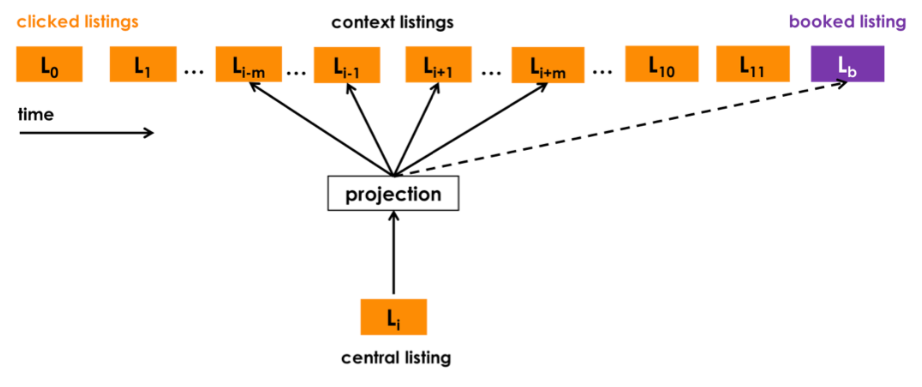

Есть еще одна интересная модификация, которую используют для торговых площадок Alibaba.

Вместо word2vec здесь используется DeepWalk, который использует ту же идею Skip-gram, но для составления эмбеддингов графовых структур. Его ключевая особенность — это случайные блуждания, которые используются вместо обычного фиксированного контекста в word2vec.

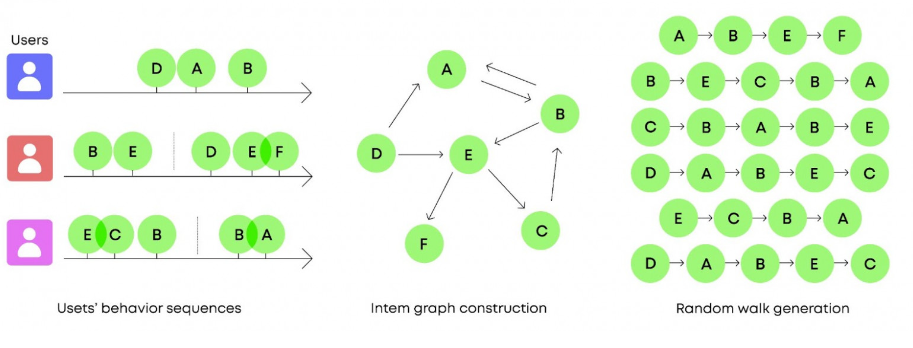

Плюсы: 
* Улавливание семантических и контекстуальных связей между объектами
* Эффективная обработка больших объемов данных
* Гибкость настройки гиперпараметров для оптимизации модели

Минусы: 
* Зависимость от качества и объема данных
* Игнорирование структурированной информации и сложных взаимосвязей
* Сложности с настройкой и выбором оптимальных гиперпараметров, требовательность к ресурсам

# Алгоритмы Learning to Rank

Главное отличие алгоритмов LTR от традиционного ML в том, что, если традиционно предсказание строится для одного объекта в один момент времени, то LTR работает со всем списком, оценивая ранжирование в целом. Это дает возможность отсортировать не просто по признаку «посмотрел пользователь или нет», а используя реальный порядок просмотра и оценивая взаимное расположение объектов в ленте. Тренировочные данные для LTR состоят из некоторого истинного порядка расположения рекомендаций, который модель обучается повторять. Есть несколько подходов к построению ранжирования.

Pointwise — это обычная задача регрессии: нужно проассоциировать каждый объект с неким числом (оценкой) и затем в соответствии с ним ранжировать.

Pairwise-подход — это попытка задать функцию отношения на множестве объектов. То есть, модель получает на вход два объекта и должна выдать вероятность того, что первый из них больше подходит пользователю, чем второй. Вообще говоря, при таком подходе мы не получаем математически выверенной операции, могут быть накладки в виде невыполнения ассоциативности, транзитивности или других свойств — методы обучения Pairwise модели не всегда гарантируют их соблюдение. Тем не менее, он гораздо лучше отвечает задаче ранжирования, чем Pointwise.

И, наконец, listwise-подход, когда оценивается все ранжирование целиком. Можно прямо оптимизировать такие метрики, как NDCG.

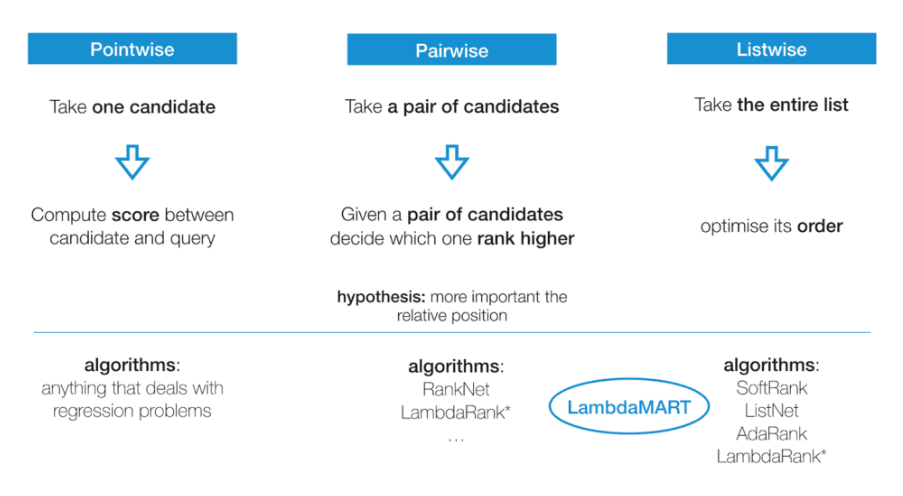

# RankNet

RankNet — это вариант pairwise подхода, придуманный в 2005 году. Он предполагает наличие размеченных обучающих примеров для некоторых пар контента. 

В RankNet модель может быть любой, обычно это нейросеть, хотя может быть и ансамбль деревьев. RankNet преобразует входной вектор фич x для элемента в оценку s. А затем пара оценок преобразуется в значение вероятности, что первый элемент более релевантен, чем второй.

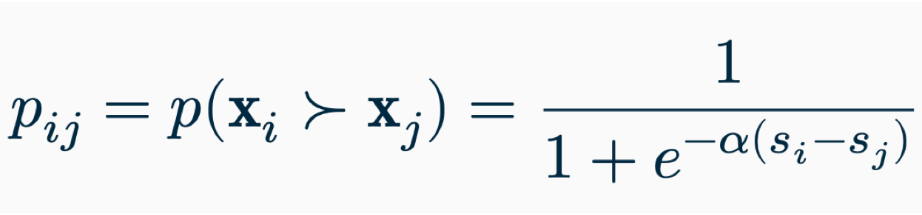

Функцией ошибки выступает кросс-энтропия:

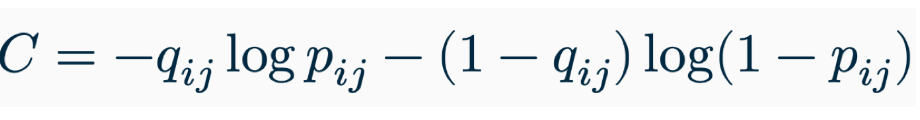

Если у нас есть точные оценки релевантности, и S для пары i,j принимает значения {-1, 0, +1}, то получаем симметричную ошибку:

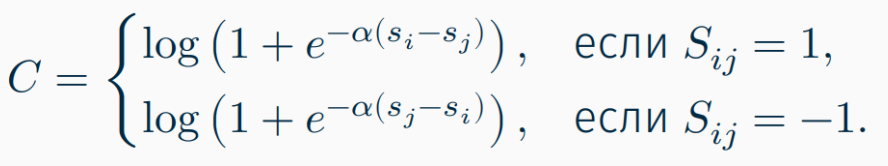

Веса:

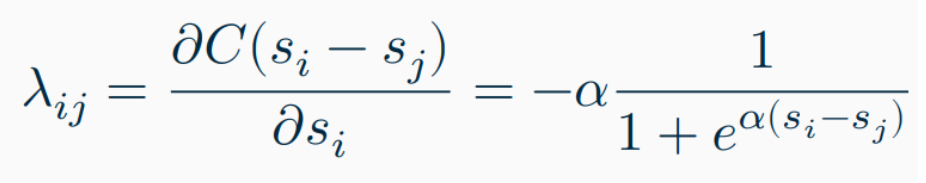

Обучается модель с помощью градиентного спуска. Получается алгоритм, направленный на минимизацию инверсий в ранжировании, где инверсии — это неправильно расставленные пары элементов. Уменьшая их количество, алгоритм приближается к идеальному ранжированию.

Плюсы:
* Высокая точность ранжирования: RankNet эффективно обучается на основе парных сравнений, что позволяет модели учитывать относительную значимость объектов.
* Гибкость и адаптивность: Архитектура RankNet основана на нейронных сетях, что позволяет ей моделировать сложные нелинейные зависимости между признаками объектов.
* Обучение с учетом относительных позиций: Вместо абсолютных оценок, RankNet обучается на основе относительных позиций объектов, что позволяет лучше учитывать предпочтения пользователей.

Минусы:
* Высокие вычислительные затраты: Обучение RankNet требует обработки большого количества пар объектов, что увеличивает вычислительные ресурсы и время обучения.
* Сложность настройки и оптимизации: Архитектура нейронной сети включает множество гиперпараметров, таких как количество слоев, количество нейронов, скорость обучения и др.
* Необходимость большого объема разметки данных: Для эффективного обучения RankNet требуется большое количество парных сравнений, что подразумевает необходимость наличия разметки данных с учетом предпочтений пользователей.

# LambdaRank

Следующим шагом посмотрим на работу сразу с целым списком ранжирования.

Рассмотрим listwise-подход, который позволит оптимизировать напрямую NDCG. LambdaRank — это старый подход, родом он из 2007 года. Рассматривая формулу метрики, можно вспомнить, что сама ошибка не нужна, а нужны только градиенты. Нас не интересуют абсолютные значения NDCG, нам нужна такая «сила», которая будет толкать вниз некий элемент, если тот случайно расположился выше более релевантного, увеличивая таким образом NDCG по отношению к исходному значению (каким бы оно ни было).

NDCG нужно максимизировать, так что берём:

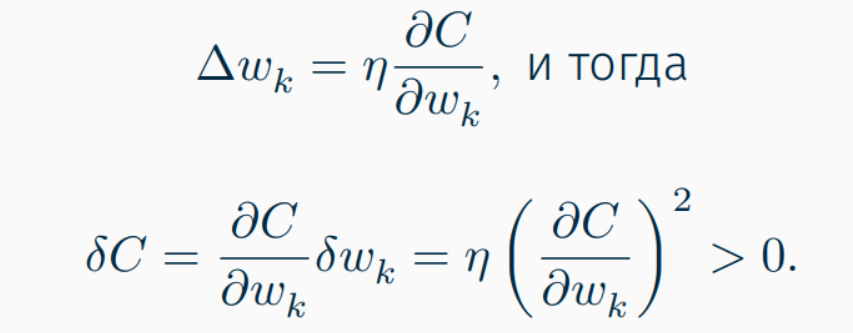

Оказывается, что такой подход фактически напрямую оптимизирует NDCG (сглаженную версию). Таким образом, можно не знать функцию, а просто придумать подходящие градиенты. По лемме Пуанкаре это такие, чтобы под них существовала функция, чтобы сходились вторые частные производные. Более того, если мы хотим оптимизировать некоторые другие метрикии, такие как MRR или MAP, то LambdaRank можно изменить для достижения этой цели.

Плюсы:
* Прямая оптимизация метрик ранжирования: LambdaRank разработан для оптимизации специфических метрик ранжирования, таких как NDCG, что делает его более целенаправленным по сравнению с RankNet.
* Эффективное использование градиентов: LambdaRank применяет лямбда-градиенты, которые учитывают влияние каждой пары документов на итоговую метрику ранжирования.
* Улучшенная производительность: В практических приложениях LambdaRank обычно демонстрирует лучшие результаты по сравнению с базовыми моделями ранжирования.
Минусы:
* Сложность реализации: Внедрение LambdaRank требует более сложных вычислений лямбда-градиентов и дополнительной логики по сравнению с базовыми моделями ранжирования.
* Высокие вычислительные затраты: Оптимизация специфических метрик ранжирования и обработка большого количества парных сравнений требует значительных вычислительных ресурсов.
* Необходимость качественной разметки данных: Для эффективного обучения LambdaRank требуется наличие хорошо размеченных парных сравнений, отражающих предпочтения пользователей.

# Wide & Deep Learning for Recommender Systems

Embedding-based модели вроде factorization machines или Deep-NN хорошо обобщают, но исходная матрица взаимодействий крайне разрежена и велика, так что юзеры со специфическими вкусами (или специфический контент) часто получают не очень качественные рекомендации. Более простые линейные модели могут вычислить такие «исключения» по меньшему количеству параметров. Кроме того, линейные модели хорошо интерпретируются, но плохо обобщают — и неспособны ловить ложные зависимости.

В 2016 году Google разработал комбинированную модель для рекомендации приложений в Google Play. Поскольку число приложений велико, то предварительно производится отбор кандидатов (комбинацией модели и эмпирических правил), а затем список приложений-кандидатов поступает на вход модели, которая их оценивает по вероятности установки. Далее, исходя из этой оценки, приложения ранжируются и предлагаются пользователю.

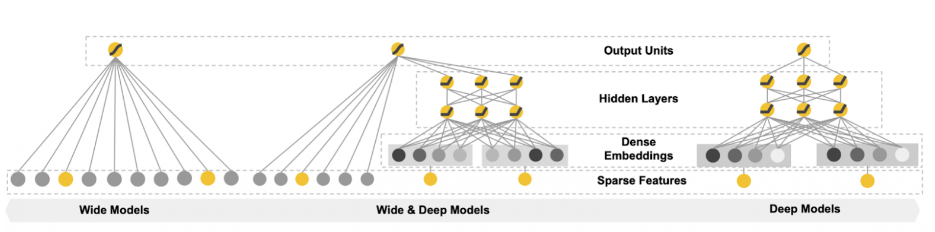

Wide Component

Этот компонент описывается как: y = wT*x + b. Фичи x включают как сырые входные переменные (one-hot encoded категориальные признаки пользователя и контента), так и трансформированные. Главное преобразование, которое здесь применяется — это cross-product transformation, произведения фич. Для бинарных фич это эквивалентно логическому «И» оператору: добавляет нелинейности и помогает улавливать взаимное влияние разных фич.

Deep Component

Это нейросеть, где входные категориальные признаки предварительно кодируются one-hot. Затем это разреженное представление преобразуются в плотные вектора эмбеддингов (обычно размерности 10–100), по своему вектору на каждую категориальную фичу. Далее они конкатинируются и пропускаются через 3 полносвязных слоя с ReLU активацией.

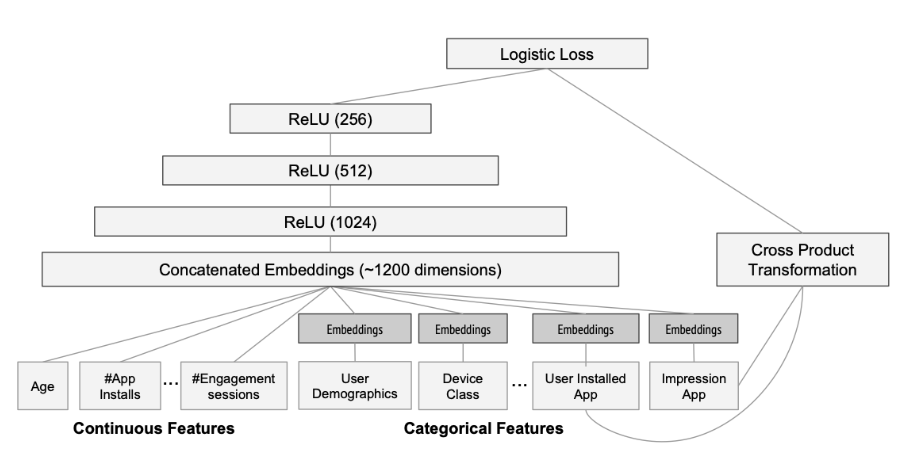

От предсказаний wide- и deep- компонент берется взвешенная сумма и считается совместный log loss, обе части тренируются совместно. Цель wide-части — дополнить слабые места deep-компонента, потому сама по себе эта модель не обязана быть большой или по-настоящему точной (потому число cross-product фич может быть небольшим).

Этот алгоритм показывает необходимость учитывать как коллаборативные фичи, так и более простые (но содержащие полезную дополнительную информацию) фичи контента и пользователей. К тому же он учитывает интересы как активных, так и менее активных пользователей. Модели смешанного типа не ограничиваются Wide & Deep алгоритмом, но он имеет довольно широкое применение в настоящее время.

Плюсы:
* Комбинация линейных и нейронных сетей: Позволяет эффективно обрабатывать как простые, так и сложные зависимости в данных, соединяя преимущества линейных моделей (широкая часть) и глубоких нейронных сетей (глубокая часть).
* Гибкость в применении: Подходит для различных задач, включая рекомендательные системы и рекламные модели, благодаря способности одновременно учитывать как категориальные, так и числовые признаки.
* Хорошая масштабируемость: Способен эффективно работать с большими объемами данных и высокоразмерными признаками, что важно для промышленных приложений.

Минусы:
* Сложность настройки: Требует тщательной балансировки между широкой и глубокой частями модели, что может усложнять процесс обучения и тюнинга.
* Меньшая способность к моделированию сложных взаимодействий: По сравнению с более продвинутыми архитектурами, такими как DLRM, может быть ограничен в способности захватывать сложные нелинейные связи между признаками.
* Зависимость от качественной подготовки признаков: Для достижения оптимальной производительности требуется тщательная инженерия признаков и предварительная обработка данных.

# DLRM (Deep Learning Recommendation Model)

DLRM от Facebook имеет структуру, аналогичную архитектуре нейронной сети с метаданными, но обладает некоторыми специфическими отличиями. Датасет может содержать несколько категориальных признаков. DLRM требует, чтобы все категориальные вводы передавались через эмбеддинг-слой с одинаковой размерностью. 

Далее непрерывные вводы конкатенируются и подаются через несколько полностью связанных слоев, называемых нижним многослойным перцептроном (Multilayer Perceptron. MLP). Последний слой нижнего MLP имеет ту же размерность, что и векторы эмбеддинг-слоя.

DLRM использует новый комбинированный слой. Он применяет поэлементное умножение между всеми парами эмбеддинг-векторов и выходом нижнего MLP. По этой причине каждый вектор имеет одинаковую размерность. Полученные векторы конкатенируются и подаются через другой набор полностью связанных слоев (верхний MLP).

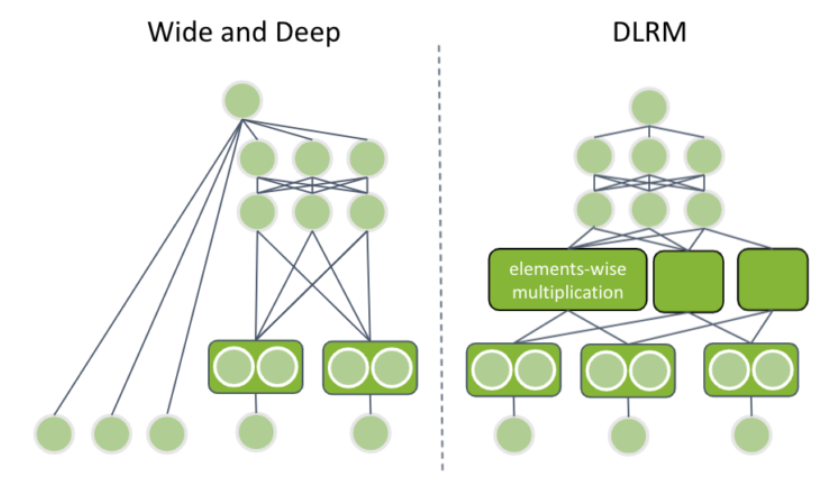

Плюсы:
* Оптимизирован для рекомендательных систем: Специально разработан для обработки больших объемов категориальных данных и взаимодействий между ними, что улучшает качество рекомендаций.
* Эффективные техники взаимодействия признаков: Включает продвинутые методы моделирования взаимодействий между признаками, такие как фишковые взаимодействия (feature interactions), что повышает способность модели к предсказанию сложных зависимостей.
* Высокая масштабируемость и производительность: Разработан для работы в распределённых системах, что обеспечивает эффективное обучение и инференс на больших датасетах.

Минусы:
* Сложность архитектуры: Более сложная структура модели по сравнению с Wide & Deep может требовать больше вычислительных ресурсов и времени на настройку.
* Высокие требования к экспертизе: Для эффективного использования DLRM необходимы глубокие знания в области глубокого обучения и обработки данных, что может затруднять его внедрение.
* Избыточность для простых задач: В случаях, когда задача не требует сложного моделирования взаимодействий, использование DLRM может быть неоправданно ресурсозатратным.

# Sequence-based

Sequence-based нейросетевой подход для рекомендательных систем обычно основан на рекуррентных нейронных сетях (RNN), таких как LSTM (Long Short-Term Memory) или GRU (Gated Recurrent Unit). Структура сети:

1. Эмбеддинги элементов: Каждый элемент последовательности представляется в виде векторного эмбеддинга. 

2. LSTM слои: LSTM является типом рекуррентной нейронной сети, способной учитывать долгосрочные зависимости в последовательности. Модель на основе LSTM состоит из нескольких слоев LSTM, каждый из которых имеет входной вектор (эмбеддинг элемента) и выходной вектор.

3. Последовательное предсказание: На первом шаге модель принимает начальную последовательность элементов и проходит через слои LSTM. Выходной вектор последнего LSTM слоя передается в полносвязный слой, который предсказывает вероятности следующего элемента в последовательности.

4. Обучение модели: Для обучения модели используется метод обратного распространения ошибки (backpropagation). Модель минимизирует ошибку предсказания следующего элемента с помощью метода оптимизации, такого как стохастический градиентный спуск.

5. Предсказание: После обучения модель использоваться для предсказания следующего наилучшего элемента в последовательности для конкретного пользователя.

Этот подход позволяет модели учитывать порядок действий пользователя и предсказывать следующий элемент, основываясь на контексте и зависимостях между элементами последовательности. 

# Self-Attentive Sequential Recommendation (SASRec)

SASRec — это один из более новых (2018 года) и сложных подходов, использующих механизм внимания. Этот подход позволяет выделять сложные закономерности подобно RNN-моделям, но снизить требования к объемам обучающей выборки.

На каждом шаге SASRec пытается определить, какие действия являются наиболее важными из истории пользователя, и использовать их для прогнозирования следующего действия. еханизм self-attention, схема которого приведена ниже, отлично зарекомендовал себя в задачах описания изображений, обобщения текста, машинном переводе. В некотором смысле, эти задачи похожи на рекомендации.

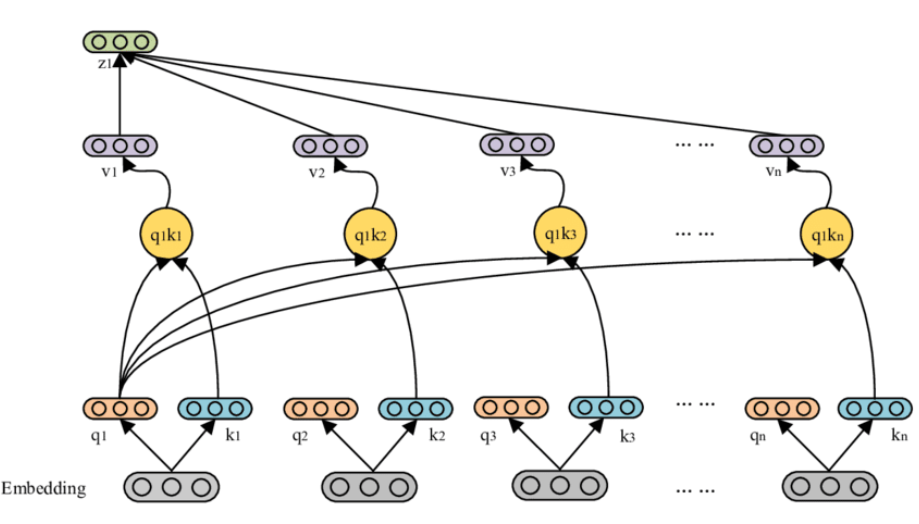

SASRec вдохновлена Transformer-нейросетями. Кроме self-attention-механизма SASRec включает слой Embedding, который состоит из эмбеддингов контента и позиции его в последовательности.

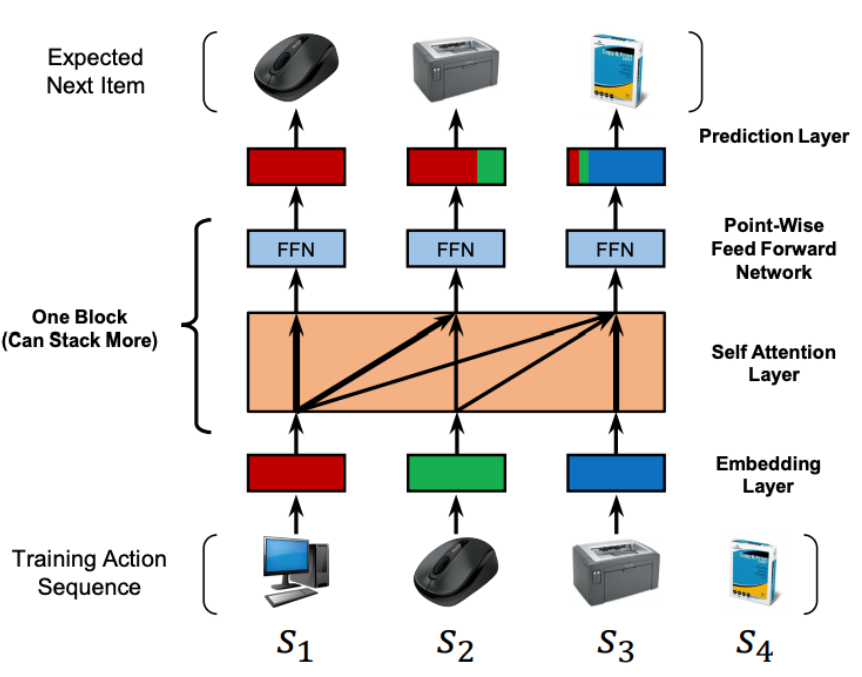

Кроме того, здесь используется Point-Wise Feed-Forward Network для усложнения модели и добавления нелинейности. Она представляет из себя двухслойную сеть с общими для всех входов параметрами.

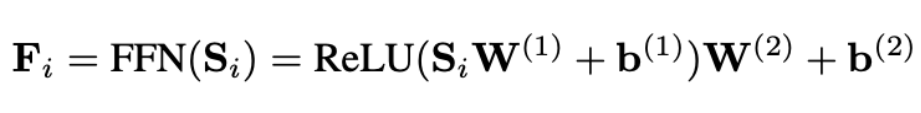

Плюсы:
* Моделирование долгосрочных зависимостей: Использует механизм self-attention для эффективного захвата долгосрочных зависимостей в последовательностях пользовательских взаимодействий, что улучшает качество рекомендаций.
* Параллельная обработка: Благодаря архитектуре на основе трансформеров позволяет обрабатывать последовательности параллельно, что ускоряет обучение и инференс по сравнению с рекуррентными нейронными сетями.
* Гибкость в обработке последовательностей разной длины: Способен эффективно работать с последовательностями различной длины без необходимости фиксирования размера входа, что делает модель универсальной для разнообразных данных.

Минусы:
* Высокие вычислительные требования: Архитектура трансформеров требует значительных вычислительных ресурсов и памяти, особенно при работе с длинными последовательностями.
* Сложность обучения: Настройка гиперпараметров и обучение модели может быть сложным процессом, требующим глубокого понимания архитектуры и особенностей данных.
* Ограниченная способность учитывать внешние контексты: Фокусируется в основном на последовательностях взаимодействий пользователя, что может недостаточно учитывать внешние факторы, влияющие на предпочтения пользователя.

# BERT4Rec

Рисерчеры из Alibaba в 2019 году впервые подружили BERT-ы и Recsys, представив архитектуру BERT4Rec. Вообще, идея логично проистекает из SASRec - если модели с однонаправленным контекстом (unidirectional models) отлично справились с бенчмарками Recsys, почему бы не поставить эксперимент над моделями с двунаправленными контекстом (bidirectional models).

Таким образом можно:

Обусловить item-ы контекстом справа, получив их лучшее представление, и заодно значительно увеличить обучающую выборку (комбинаторный взрыв количества перестановок маскированных item-ов и немаскированных).

Смягчить предположение о жесткой упорядоченности item-ов в последовательности, которая соблюдается не всегда.

Обучали модель на задаче MLM (Masked Language Modelling) или Cloze task, маскируя определенную долю случайных item-ов в последовательности. Во время теста достаточно подать на вход последовательность item-ов с [mask] в самом конце, подсказывая таким образом модели, какое поведение мы от нее ожидаем.

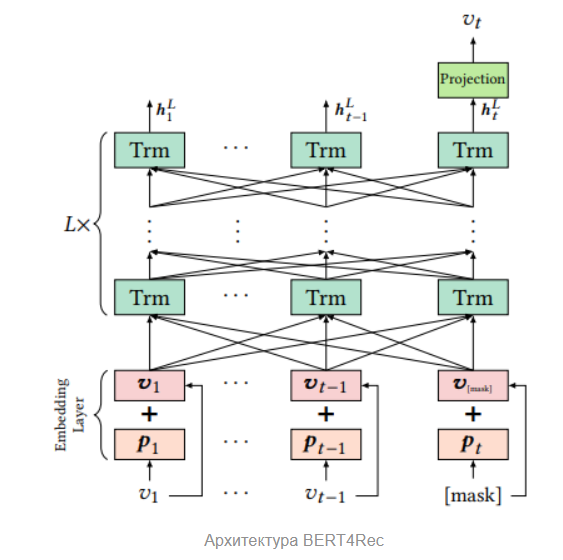

Плюсы:
* Двунаправленное моделирование контекста: Использует двунаправленные трансформеры, позволяющие учитывать как предшествующие, так и последующие элементы в последовательности, что улучшает точность предсказаний.
* Маскированное обучение: Применение техники маскирования элементов последовательности способствует более эффективному обучению и позволяет модели лучше предсказывать пропущенные элементы.
* Предварительное обучение: Возможность использования предобученных моделей BERT для рекомендаций обеспечивает улучшение качества рекомендаций благодаря переносу знаний из других задач.

Минусы:
* Высокая вычислительная сложность: Двунаправленная архитектура трансформеров требует значительных вычислительных ресурсов и памяти, что может затруднять масштабирование модели на больших данных.
* Длительное время обучения: Обучение модели может занимать много времени, особенно при работе с большими объемами данных и длинными последовательностями.
* Сложность интерпретации: Сложная архитектура трансформеров затрудняет интерпретацию внутренних процессов модели и понимание того, как принимаются конкретные решения, что может быть критично для некоторых приложений.

# Beyond Self-Attention for Sequential Recommendation (BSARec)

BSARec - один из более новых и сложных подходов, использующих механизм внимания, выявляет зависимости по последовательности взаимодействий. Этот подход позволяет выделять сложные закономерности подобно RNN-моделям, но снизить требования к объемам обучающей выборки. Решает 2 проблемы предыдущих Sequential Recommendation моделей - недостаточное индуктивное смещение и чрезмерное сглаживание частот. С помощью Фурье преобразования, BSARec получает доступ к индуктивному смещению частот, позволяя улавливать важные закономерности и периодичность, которые можно не заметить, используя только self-attention механизм трансформеров. В архитектуру введён преобразователь частоты, который может захватывать как высокочастотные модели поведения, обусловленные краткосрочными тенденциями, так и низкочастотные, обусловленные долгосрочными интересами, в поведенческих моделях пользователя. 

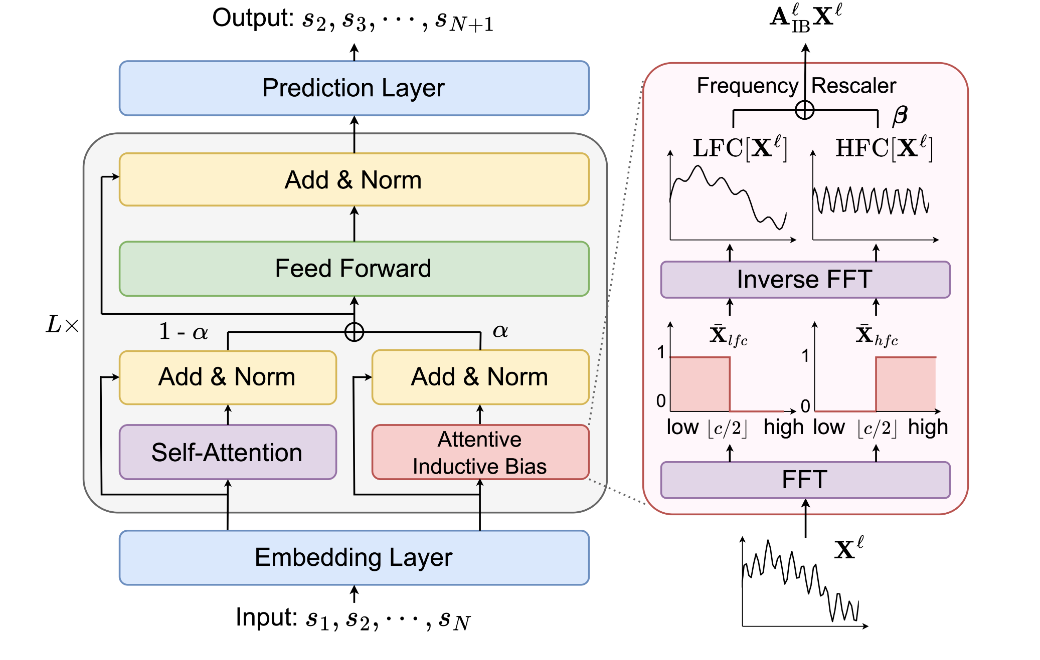

Минусы: 
* Вычислительная сложность
* Ограниченность объема данных
* Недостаток интерпретируемости

# TRON

Session-based рекомендательные системы предсказывают следующие item базируясь на сессии - последовательности item-ов, с которыми он взаимодействовал ранее. Выбирать негативные примеры можно несколькими способами:

* Из равномерного распределения над всеми item-ами

* Из распределения, полученного из частоты взаимодействия каждого item-а с каждыми user-ом

* Комбинация из 1. и 2.

Сэмплировать негативные примеры можно по одному: на каждое позитивное взаимодействие (elementwise), на каждую сессию (sessionwise), на каждый батч (batchwise). Element-wise подход страдает тем, что содержит в себе особую вычислительную сложность, в то время как другие подходы более быстрые.

TRON применяет комбинацию из sessionwise и batchwise подходов, при этом использует top-k сэмплирование. При этом все это поверх SASRec c Sampled Softmax Loss.

Были проведены эксперименты над 2мя вариантами комбинаций техник семплирование: uniform+sessionwise, batchwise+sessionwise, в рамках которых было установлено, что при достаточно большом количестве негативных примеров TRON выигрывает все остальные модели, попавшие в сравнение в большинстве случаев.

Плюсы:
* Эффективное масштабирование: TRON способен обрабатывать большие объемы сессионных данных благодаря оптимизированным методам негативного сэмплинга и функциям потерь, сохраняя высокую производительность при росте данных.
* Улучшенное качество рекомендаций: Оптимизация функций потерь обеспечивает более точное обучение модели, повышая точность и релевантность рекомендаций для пользователей.
* Использование трансформеров: Архитектура на основе трансформеров позволяет эффективно моделировать последовательности и захватывать сложные зависимости между элементами сессии.

Минусы:
* Высокие вычислительные ресурсы: Несмотря на оптимизации, трансформеры требуют значительных вычислительных мощностей и памяти, что может быть дорогостоящим.
* Сложность реализации: Интеграция оптимизированного негативного сэмплинга и специализированных функций потерь может потребовать значительных усилий при разработке и настройке модели.
* Трудности с интерпретацией: Модели на основе трансформеров, включая TRON, сложны для интерпретации, что затрудняет объяснение рекомендаций пользователям или аналитикам.

# FISSA: Fusing Item Similarity Models with Self-Attention

Рекомендательные модели, учитывающие последовательность действий, увеличивают точность за счет учета динамики предпочтений. При этом постоянные и глобальные предпочтения недооцениваются. FISSA — это state-of-the-art модель на последовательностях событий с self-attention механизмом, которая балансирует локальные (динамические) предпочтения пользователя и глобальные.

Для локальных (динамических) предпочтений берется SASRec, как хорошо зарекомендовавший себя метод. Для учета глобальных предпочтений используется location-based (основанный на позиции в пространстве) attention-слой.

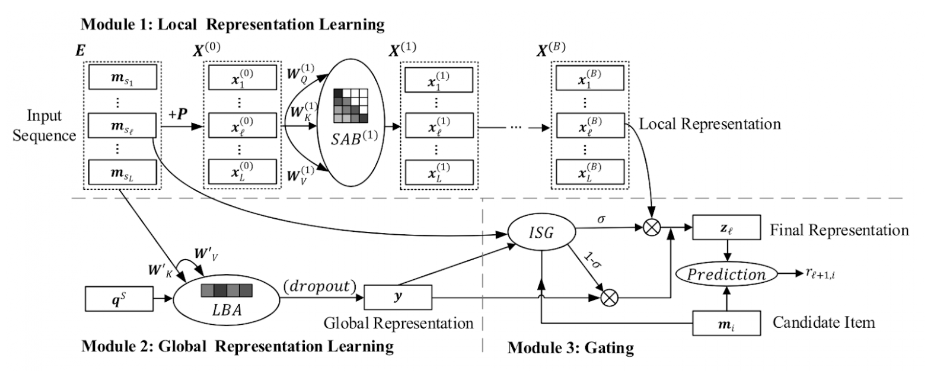

Здесь используется implicit feedback: то есть на вход поступает последовательность из L последних объектов с которыми взаимодействовал пользователь. Цель —  выдать список рекомендаций, в котором реальный следующий объект взаимодействия будет как можно ближе к началу списка.

Плюсы:
* Высокая точность рекомендаций: FISSA использует факторизационные методы для эффективного моделирования пользовательских предпочтений и взаимодействий, что приводит к более точным и персонализированным рекомендациям.
* Интеграция дополнительной информации: Система способна учитывать различные источники данных, такие как демографические параметры пользователей и контекст сессии, улучшая качество рекомендаций за счет более полного понимания предпочтений.
* Масштабируемость: Благодаря оптимизированной архитектуре, FISSA может обрабатывать большие объемы сессионных данных без существенного снижения производительности, что делает её подходящей для крупных платформ.

Минусы:
* Сложность настройки и интеграции: Внедрение FISSA требует значительных усилий по настройке параметров модели и интеграции с существующими системами, что может усложнить процесс внедрения.
* Высокие вычислительные затраты: Факторизационные методы и интеграция множественных источников данных требуют значительных вычислительных ресурсов, что может увеличить стоимость эксплуатации системы.
* Ограниченная интерпретируемость: Несмотря на высокую точность, внутренние механизмы работы FISSA могут быть сложно интерпретируемы, что затрудняет понимание причин конкретных рекомендаций как для разработчиков, так и для конечных пользователей.

# Collaborative Memory Networks (CMN)

Немного отойдем от sequential, но продолжим с механизмом внимания.

Еще один пример комбинированной модели 2018 года, сочетающей в себе нейросеть типа Memory Augmented с attention-механизмом, которая при этом учитывает сильные стороны матричного разложения.

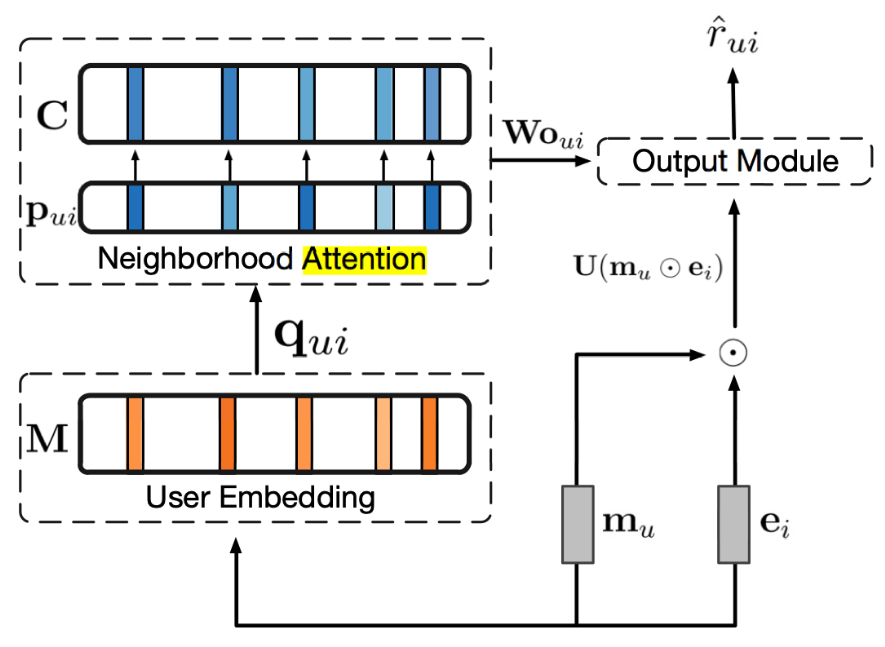

Схема модели на картинке. Компонент памяти состоит из матриц с факторами пользователей и объектов. Вектор рекомендаций строится на механизме схожести, где для каждого пользователя v, который взаимодействовал с объектом i, оценивается схожесть пользователей v и u (целевого), а также уверенность в предпочтениях пользователя v относительно объекта i. В качестве явного фидбэка в данной модели может использоваться просто рейтинг.

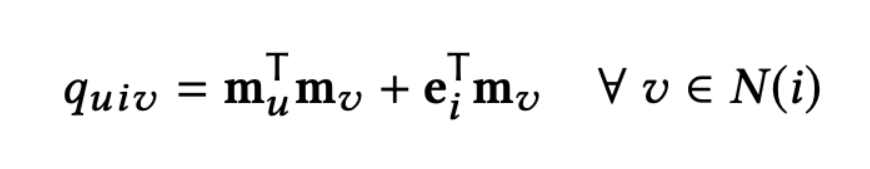

Это похоже по сути своей на матричное разложение или методы ближайших соседей (k-NN). Но в методе ближайших соседей заранее выбирается константа k – количество соседей, мнения которых мы усредняем. В матричном разложении заранее выбирается функция схожести, например косинусное сходство (cosine similarity).

Механизм внимания позволяет заменить эмпирический выбор на обучаемые коэффициенты для взвешенного вклада других пользователей.

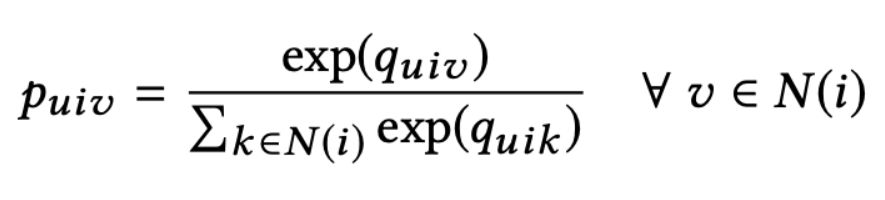

В итоге эмбеддинги из компонента памяти взвешиваются с коэффициентами внимания и суммируются.

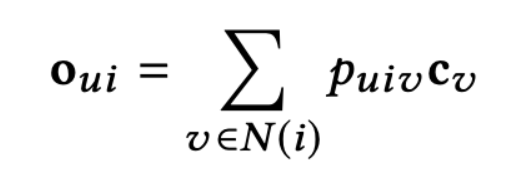

Плюсы:
* Эффективное управление информацией: CMN используют общую память, которая позволяет нескольким агентам или компонентам модели обмениваться информацией. Это улучшает способность системы сохранять и извлекать релевантные данные, что особенно полезно для сложных задач с длительной зависимостью.
* Улучшенная координация и сотрудничество: Благодаря совместному использованию памяти, различные части сети могут лучше координировать свои действия и принимать более информированные решения. Это повышает общую производительность системы в многозадачных или многоагентных сценариях.
* Гибкость и масштабируемость: CMN могут легко масштабироваться для обработки больших объемов данных или увеличения числа агентов без существенного ухудшения производительности. Их архитектура позволяет добавлять новые компоненты или расширять память без перепроектирования всей системы.

Минусы:
* Высокие вычислительные затраты: Совместное использование памяти требует значительных вычислительных ресурсов для синхронизации и управления доступом к общей памяти. Это может приводить к увеличению времени обучения и инференса, особенно при работе с большими моделями.
* Сложность обучения и настройки: Настройка параметров CMN и обеспечение эффективного взаимодействия между компонентами может быть сложной задачей. Требуется тщательная настройка гиперпараметров и архитектуры памяти для достижения оптимальных результатов, что требует значительных усилий и экспертизы.
* Проблемы с интерпретируемостью: Из-за сложности взаимодействий между различными частями сети и использования общей памяти, понимание внутренних процессов и причин принятия конкретных решений становится затруднительным. Это ограничивает возможность анализа и отладки модели, а также доверие к её выводам в критически важных приложениях.

# Collaborative Variational Autoencoder (CVAE)

Сейчас в рекомендациях широко используются адаптации моделей, хорошо зарекомендовавших себя в других различных областях. Например, вариационные автоэнкодеры (VAE).

Это модель 2017 года, которая учитывает и коллаборативную информацию, и содержание (в данном случае текст, но можно адаптировать под другие типы контента) внутри одной VAE-модели. 

Гибридные (учитывающие оба вида информации) системы делятся на слабосвязные и сильносвязные. Слабосвязные по сути представляют собой две отдельные модели, связанные отдельной моделью или эвристиками. Большей отказоустойчивостью обладают, разумеется, сильносвязные модели. По сути, это модель генерации эмбеддингов, которые генерируются как из содержания (unsupervised), так и из коллаборативный информации.

В качестве основы используется модель probabilistic matrix factorization (PMF), которые сворачивают коллаборативную информацию каждого объекта в эмбеддинги (которые подчиняются нормальному распределению).

Общая схема сети выглядит таким образом: 

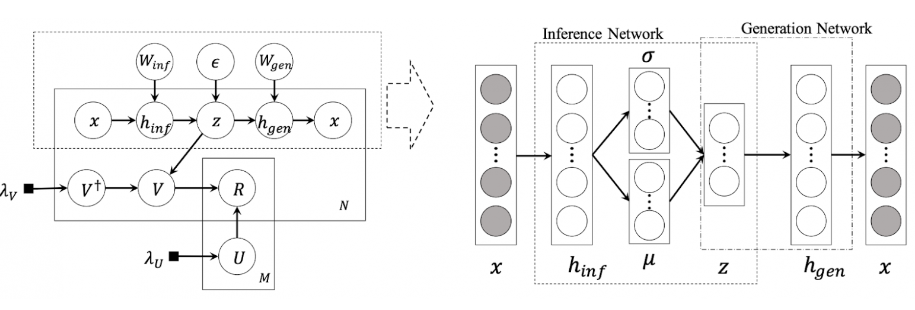

Скрытая переменная объекта при этом составляется из коллаборативный скрытой переменной и скрытой переменной содержимого контента.

Тестирование модели проводилось на датасетах сервиса для сбора статей CiteULike со случайным (а не по времени) разбиением на тренировочный и тестовый наборы. Метрикой выбрана recall@M. CVAE алгоритм показывает лучшие результаты по сравнению с такими методами, как Collaborative Deep Learning, Collaborative Topic Regression и DeepMusic.

# MultiVAE

В основе MultiVAE лежит предположение о том, что пользовательские взаимодействия с предметами можно моделировать как многомерное распределение, и задача модели — эффективно захватить эти распределения для качественных рекомендаций.

MultiVAE использует архитектуру вариационного автоэнкодера для обучения скрытого представления пользователей и предметов на основе их взаимодействий. Вот основные этапы работы модели:
1. Входные Данные:
   - Входными данными являются матрицы взаимодействий пользователей и предметов, где элементы матрицы представляют неявные взаимодействия (например, количество просмотров или кликов).
2. Энкодер:
   - Энкодер преобразует входные данные (например, вектор взаимодействий пользователя) в распределение вероятностей скрытых переменных (обычно многомерное нормальное распределение).
   - Это включает в себя вычисление параметров (среднее и ковариация) для скрытого пространства.
3. Сэмплирование:
   - Из распределения, полученного энкодером, производится сэмплирование скрытого представления с использованием метода reparameterization trick для обеспечения дифференцируемости процесса обучения.
4. Декодер:
   - Декодер берет сэмплированное скрытое представление и реконструирует исходные данные, предсказывая вероятности взаимодействий пользователя с различными предметами.
   - В MultiVAE часто используется многономиальное распределение Лапласа (multinomial likelihood), что лучше подходит для моделирования неявных обратных связей.
5. Обучение:
   - Модель обучается путем максимизации нижней границы вариационного вывода (ELBO), которая включает два компонента:
     - Реконструктивная ошибка: насколько хорошо декодер может восстановить исходные данные.
     - Регуляризация: насколько близко распределение скрытых переменных к заранее заданному априорному распределению (обычно стандартное нормальное распределение).
6. Рекомендации:
   - После обучения, для нового пользователя или предмета, модель может предсказывать вероятности взаимодействий, предоставляя персонализированные рекомендации.

Плюсы:
* Способность Обрабатывать Неявные Обратные Связи: MultiVAE специально разработан для работы с неявными данными (например, просмотры, клики), что делает его эффективным для рекомендательных систем, где явные отзывы (оценки) могут быть ограничены.
* Глубокое Обучение Скрытых Представлений: Благодаря использованию VAE, модель способна захватывать сложные распределения и зависимости в данных, создавая более точные и обоснованные скрытые представления пользователей и предметов.
* Устойчивость к Разреженности Данных: MultiVAE хорошо справляется с разреженными матрицами взаимодействий, что часто встречается в реальных рекомендательных системах, обеспечивая качественные рекомендации, даже при наличии большого количества пропущенных значений.

Минусы:
* Сложность Обучения и Настройки: VAE-архитектуры требуют тонкой настройки гиперпараметров (например, размера скрытого пространства, коэффициентов регуляризации), что может быть ресурсоёмким и требует значительного опыта для достижения оптимальных результатов.
* Высокие Вычислительные Требования: Обучение глубоких моделей, таких как MultiVAE, может потребовать значительных вычислительных ресурсов и времени, особенно на больших наборах данных. Это может ограничить применимость модели в реальных приложениях с ограниченными ресурсами.
* Трудности с Интерпретацией: Как и многие глубокие модели, MultiVAE может быть сложным для интерпретации. Понять и объяснить, почему модель рекомендует определенные предметы, может быть сложнее по сравнению с более простыми и интерпретируемыми моделями, такими как матричная факторизация.

# Reinforcement Learning

Небольшой скачок к еще одному принципиально отличающемуся от предыдущих подходу.

Простые дифференцируемые метрики плохо коррелируют с реальными бизнес-метриками, к тому же запирают нас в кольцо самосбывающихся пророчеств. Возможный выход — Reinforcement Learning (RL), где существует награда (действующего агента), которая может быть вообще любой.

Для начала немного о базовых понятиях RL.

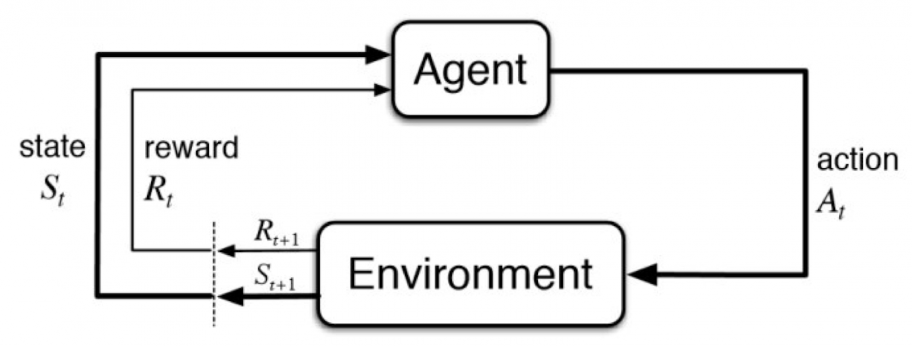

Так выглядит среда в которой мы существуем: состояния, действия, награды, переходы в новые состояния (могут быть вероятностными). Задача — максимизация суммарной награды. Policy — стратегия: набор действий для каждого состояния (или вероятностей, если наша стратегия стохастическая).

Value function — это ожидаемая суммарная награда в состоянии s.

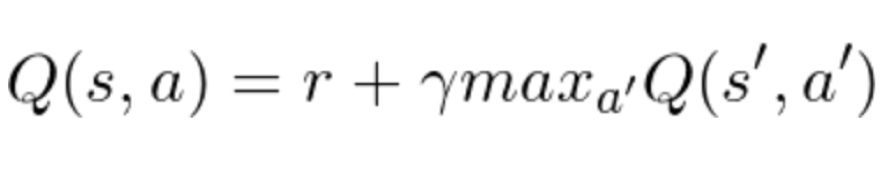

Q — функция, которая оценивает, какова будет суммарная награда, если в состоянии s мы выберем действие a. Она создана так, что ее удобно выражать рекурсивно (это называется уравнением Беллмана). Мы можем использовать это, чтобы вычислять ошибку оценки и делать поправки. Такой подход носит название Q-learning.

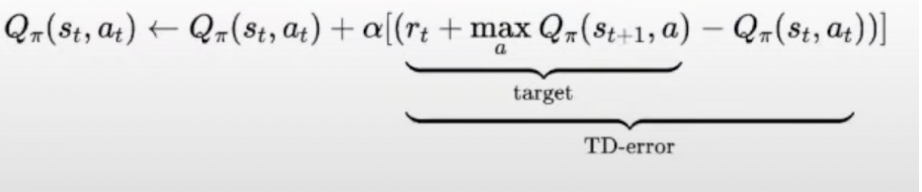

Плюсы:
* Адаптивность и динамическое обучение: RL-модели способны непрерывно адаптироваться к изменениям в предпочтениях пользователей и рыночных условиях. Они учатся на основе взаимодействий с пользователями, что позволяет рекомендациям становиться более точными и релевантными со временем.
* Оптимизация долгосрочных целей: В отличие от традиционных методов, RL позволяет учитывать не только мгновенные действия, такие как клики или покупки, но и долгосрочные метрики, такие как удержание пользователей, лояльность и общая прибыль. Это способствует созданию стратегий, направленных на устойчивый рост и улучшение пользовательского опыта.
* Персонализация и контекстуализация: RL может учитывать широкий спектр контекстуальных факторов, включая время, устройство, местоположение и предыдущие взаимодействия пользователя. Это позволяет создавать более персонализированные и релевантные рекомендации, соответствующие текущим потребностям и интересам пользователя.

Минусы:
* Высокая вычислительная сложность: Обучение RL-моделей требует значительных вычислительных ресурсов и времени, особенно при работе с большими объемами данных и сложными сценариями взаимодействий. Это может увеличить стоимость разработки и эксплуатации рекомендательных систем.
* Сложности в определении функции вознаграждения: Правильная формулировка функции вознаграждения крайне важна для успешного обучения модели. Неправильное определение вознаграждения может привести к нежелательным поведению модели, что негативно скажется на качестве рекомендаций и пользовательском опыте.
* Риск неэффективного исследования: В процессе обучения RL-модели могут предпринимать действия, которые временно ухудшают качество рекомендаций в целях исследования новых стратегий. Это может привести к снижению удовлетворенности пользователей и потенциальному оттоку аудитории, особенно на ранних этапах внедрения.


# Deep Deterministic Policy Gradient

У  применения RL в рекомендациях есть сложности. Одна из них — большое поле «возможных действий». Обычно это набор вида: пойти налево-направо-вперед-назад. Здесь же «действием» будет показ любого из миллионов (или сколько у нас есть) объектов в рекомендациях. Это делает расчёты очень дорогими.

Чтобы не считать ошибку на каждом шаге для всех возможных действий, используется подход называемый Deep Deterministic Policy Gradients (DDPG). Актор предлагает лучшее действие в текущей ситуации. Пытается максимизировать оценку критика. Критик обучается с помощью Q-learning.

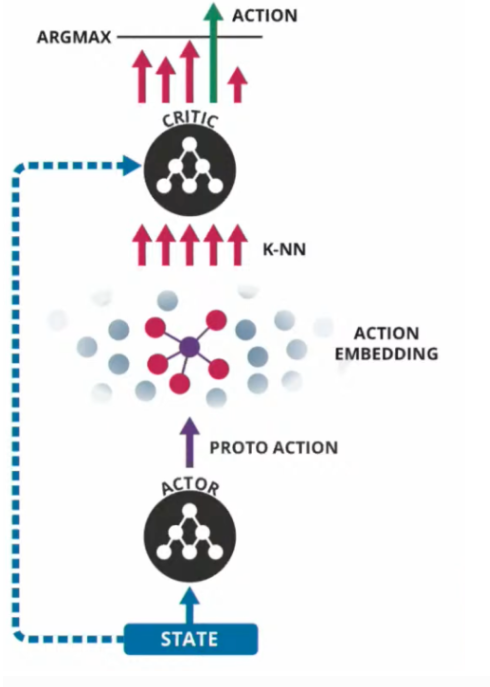

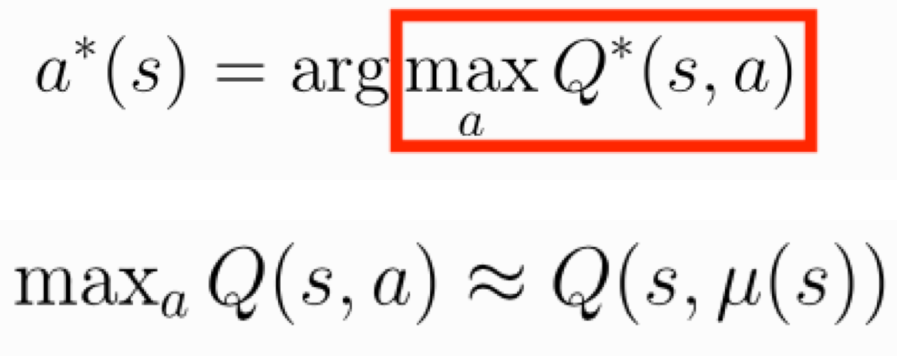

DDPG чередует обучение критика и актора. Проблема с непрерывным или большим полем возможных действий в выборе выделенного красным максимума. Там, где в обычном случае мы можем сделать выбор простым перебором, в случае непрерывного поля получаем очень дорогостоящие вычисления. С непрерывным пространством действий (для рекомендаций его роль может выполнять вектор эмбеддингов того, что нужно рекомендовать) мы можем предположить, что функция Q дифферинциируема относительно действий. Значит, можно, используя градиенты обучать стратегию (политику).

Так выглядит простая схема обучения, которая первый раз появилась в одной статье еще в 2015 году. С тех пор появилось много усовершенствованных подходов.

Может показаться, что RL идеален. Это, конечно, не совсем так. Есть ряд проблем в применении RL к рекомендательным системам. Кроме большого поля «возможных действий», есть еще проблема дорогостоящего exploration: эксперименты на пользователях могут стоить компании реальных юзеров. Еще одна сложность лежит в необходимости учить off-policy, так как большая часть оффлайн данных приходит от агента с другой policy чем та, которую мы хотим строить. Проблемой также является неявная и зашумленная «награда», поскольку мы не можем непосредственно измерить удовлетворенность пользователя. Тем не менее, плюсы весьма значительны, потому в компаниях, ориентированных на UGC, RL-подходы так или иначе пытаются сейчас внедрять.

Плюсы:
* Гибкость в обработке непрерывных пространств действий: DDPG хорошо подходит для задач, где рекомендации можно интерпретировать как непрерывные действия. Это позволяет моделировать более тонкие и разнообразные рекомендации, учитывая множество факторов и их вариаций.
* Эффективное использование опыта благодаря офлайн-обучению: DDPG использует механизм повторного использования опыта (experience replay), что повышает эффективность обучения за счет многократного использования данных о взаимодействии с пользователем. Это способствует более быстрому и стабильному обучению модели.
* Способность моделировать сложные политики через нейронные сети: Комбинация актера и критика в DDPG позволяет моделям учитывать сложные зависимости и паттерны в поведении пользователей. Глубокие нейронные сети обеспечивают высокую выразительность, что позволяет создавать адаптивные и персонализированные рекомендации.

Минусы:
* Высокая вычислительная сложность и требования к ресурсам: Обучение DDPG моделей требует значительных вычислительных мощностей и времени, особенно при работе с большими объемами данных и сложными архитектурами сети. Это может привести к высоким затратам на инфраструктуру и обслуживание системы.
* Проблемы со стабильностью обучения и сходимостью: DDPG известен своей чувствительностью к настройкам гиперпараметров и может сталкиваться с проблемами стабильности во время обучения. Неправильная настройка может привести к нестабильному поведению модели и затруднить достижение оптимальной производительности.
* Сложности при работе с дискретными действиями: Рекомендательные системы обычно оперируют дискретными категориями товаров или услуг, тогда как DDPG изначально разработан для непрерывных пространств действий. Адаптация DDPG для работы с дискретными действиями может усложнить архитектуру модели и повлиять на её эффективность.

# Графовые модели 

Графовые нейронные сети (GNN) представляют собой класс алгоритмов машинного обучения, которые могут обрабатывать данные, представленные в форме графа. В контексте рекомендательных систем граф может представлять собой социальную сеть, где узлы — пользователи, а рёбра — связи между ними.

В отличие от традиционных нейронных сетей, которые обрабатывают данные последовательно, GNN могут обрабатывать данные одновременно на нескольких уровнях, используя информацию о структуре графа. Это позволяет им учитывать не только прямые взаимодействия между объектами, но и косвенные связи через общих соседей.

Требуется предварительная обработка в виде построения графа, где вершины - пользователи, ребра - товары. Подход помогает искать косвенные связи и комплементарные товары, посредством анализа связей между пользователями.



# LightGCN

LightGCN упрощает традиционные GCN, сосредотачиваясь на ключевых компонентах, необходимых для рекомендательных задач, и исключая ненужные элементы. Основные этапы работы модели:

1. Построение Графа Пользователей и Предметов:
   - В рекомендательных системах данные представляются в виде двудольного графа, где узлами являются пользователи и предметы, а рёбрами — взаимодействия между ними (например, покупки, лайки, просмотры).

2. Графовые Сверточные Слои:
   - LightGCN использует несколько графовых сверточных слоёв для распространения информации между узлами. Каждый слой агрегирует представления соседних узлов, обновляя векторные представления пользователей и предметов.
   - В отличие от традиционных GCN, LightGCN убирает нелинейные активации и сложные функции агрегации, фокусируясь на простой линейной комбинации соседей.

3. Линейная Комбинация Представлений:
   - Представления из всех слоев комбинируются линейно, что позволяет модели учитывать информацию из разного количества шагов по графу (например, непосредственные и косвенные связи).

4. Прогнозирование и Обучение:
   - Конечные представления пользователей и предметов используются для предсказания вероятности взаимодействия между ними (например, вероятность покупки или лайка).
   - Модель обучается минимизации функции потерь, например, используя бинарную кросс-энтропию или другие метрики, подходящие для рекомендательных задач.

Плюсы: 
* Высокая Эффективность и Скорость Обучения: Благодаря упрощённой архитектуре без нелинейных активаций и сложных функций агрегации, LightGCN требует меньше вычислительных ресурсов и времени для обучения по сравнению с традиционными GCN. Это делает модель более подходящей для больших графов и реальных приложений.
* Высокая Производительность в Рекомендательных Задачах: Несмотря на упрощения, LightGCN демонстрирует конкурентоспособные или даже лучшие результаты по сравнению с более сложными моделями, что свидетельствует о важности основных компонентов графовых сетей для рекомендаций.
* Лёгкость Интеграции и Настройки: Упрощённая архитектура облегчает понимание и настройку модели. Меньшее количество гиперпараметров и отсутствие сложных операций делают LightGCN более доступным для использования и внедрения в различные системы.

Минусы:
* Ограниченная Способность Моделирования Сложных Взаимодействий: Упрощение структуры может ограничить способность модели захватывать более сложные зависимости и взаимодействия между пользователями и предметами, что может снизить качество рекомендаций в некоторых случаях.
* Зависимость от Качества Графа Входных Данных: LightGCN сильно зависит от качества построенного графа взаимодействий. Если данные о взаимодействиях пользователей с предметами неполны или содержат шум, это может негативно повлиять на производительность модели.
* Отсутствие Механизмов Для Обработки Метаданных: В базовой версии LightGCN не предусмотрены механизмы для интеграции дополнительных метаданных или контекстуальной информации (например, характеристики пользователей или предметов), что может ограничить потенциал модели в использовании дополнительной информации для улучшения рекомендаций.

## Ссылки на источники и статьи

https://arxiv.org/pdf/1905.06874.pdf - sequence-based подход на примере трансформера

https://habr.com/ru/articles/835380/ - статья про sequence-based трансформеры 

https://arxiv.org/pdf/1909.00385.pdf - SDM : Sequential Deep Matching Model как работает в рекомендациях

https://education.yandex.ru/handbook/ml/article/rekomendacii-na-osnove-matrichnyh-razlozhenij - рекомендации на основе матричных разложений

https://arxiv.org/pdf/1905.03375 - оригинальная статья про EASE 

https://arxiv.org/pdf/2006.00556 - оригинальная статья про TIFU KNN 

https://habr.com/ru/companies/prequel/articles/567648/ - обзор различных алгоритмов RecSys

https://habr.com/ru/companies/prequel/articles/573880/ - вторая часть обзора

https://arxiv.org/pdf/2402.09766 - статья Сбера со сравнением различных алгоритмов

https://telegra.ph/Ispolzovanie-nejrosetej-dlya-vashej-rekomendatelnoj-sistemy-05-19 - про нейросети в RecSys 